In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
from datetime import datetime
import argparse
import psutil
import numpy as np
import logging
import numpy as np
import tensorflow as tf
import time
import glob
from tensorflow.python.framework import ops
import math
from dotenv import find_dotenv, load_dotenv
import ftplib
from matplotlib import pyplot as plt
from collections import Counter

from scipy.stats.stats import pearsonr

nb_dir = os.path.join(Path(os.getcwd()).parents[0], 'src', 'data')
if nb_dir not in sys.path:
    sys.path.insert(0, nb_dir)
print(sys.path)
import features_selection as fs
import make_dataset as md
import build_data as bd
import get_raw_data as grd

models_dir = os.path.join(Path(os.getcwd()).parents[0], 'src', 'models')
if models_dir not in sys.path:
    sys.path.insert(0, models_dir)
import nn_real as nn

load_dotenv(find_dotenv())

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.set_option('io.hdf.default_format','table')

C:\Users\sandr\AppData\Local\conda\conda\envs\tensorflowenvironment\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['C:\\Users\\sandr\\Documents\\GitHub\\MLMortgage\\src\\data', '', 'C:\\Users\\sandr\\AppData\\Local\\conda\\conda\\envs\\tensorflowenvironment\\python36.zip', 'C:\\Users\\sandr\\AppData\\Local\\conda\\conda\\envs\\tensorflowenvironment\\DLLs', 'C:\\Users\\sandr\\AppData\\Local\\conda\\conda\\envs\\tensorflowenvironment\\lib', 'C:\\Users\\sandr\\AppData\\Local\\conda\\conda\\envs\\tensorflowenvironment', 'C:\\Users\\sandr\\AppData\\Local\\conda\\conda\\envs\\tensorflowenvironment\\lib\\site-packages', 'C:\\Users\\sandr\\AppData\\Local\\conda\\conda\\envs\\tensorflowenvironment\\lib\\site-packages\\Mako-1.0.7-py3.6.egg', 'C:\\Users\\sandr\\AppData\\Local\\conda\\conda\\envs\\tensorflowenvironment\\lib\\site-packages\\win32', 'C:\\Users\\sandr\\AppData\\Local\\conda\\conda\\envs\\tensorflowenvironment\\lib\\site-packages\\win32\\lib', 'C:\\Users\\sandr\\AppData\\Local\\conda\\conda\\envs\\tensorflowenvironment\\lib\\site-packages\\Pythonwin', 'C:\\Users\\sandr\\AppData\\Local\\conda\\con

In [2]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

RAW_DIR = os.path.join(Path(os.getcwd()).parents[0], 'data', 'raw') 
PRO_DIR = os.path.join(Path(os.getcwd()).parents[0], 'data', 'processed')
RANDOM_SEED = 123  # Set the seed to get reproducable results.
DT_FLOAT = np.float32
NP_FLOAT = np.dtype('float32')

train_dir = 'chuncks_random_1th_train' #'chuncks_random_c1mill_slices' #'chuncks_random_c1millx2_train'
valid_dir = '' # 'chuncks_random_c1millx2_valid'
test_dir = ''
train_period=[121,323] #[121,279] #[121, 143] 
valid_period=[324,329] #[280,285] #[144, 147] 
test_period=[330,342] #[286,304] #[148, 155]
batch_size=100000

print(RAW_DIR, PRO_DIR)

def get_files_dict(train_dir, valid_dir, test_dir):        
    ext = "*.h5"

    files_dict = {'train': glob.glob(os.path.join(PRO_DIR, train_dir, ext)), 
                  'valid': glob.glob(os.path.join(PRO_DIR, valid_dir, ext)), 
                  'test': glob.glob(os.path.join(PRO_DIR, test_dir, ext))}

    return files_dict

def architecture_settings(files_dict):
    architecture = {}    
    ok_inputs = True
    
    for key in files_dict.keys():
        total_records = 0
        for file in files_dict[key]:                                
            with pd.HDFStore(file) as dataset_file:
                if (ok_inputs): 
                    index_length = len(dataset_file.get_storer(key+'/features').attrs.data_columns)
                    architecture['n_input'] = dataset_file.get_storer(key+ '/features').ncols - index_length
                    architecture['n_classes'] = dataset_file.get_storer(key+'/labels').ncols - index_length
                    ok_inputs = False                
                total_records += dataset_file.get_storer(key + '/features').nrows
        architecture[key + '_num_examples'] = total_records                            
    
    architecture['total_num_examples'] = architecture['train_num_examples'] # 10000000
    return architecture

#To sum up the dataset per worker (assuming the same size of files per worker approximately):
files_dict = get_files_dict(train_dir, valid_dir, test_dir)
architecture = architecture_settings(files_dict)
print(architecture)

DATA = md.get_h5_data(PRO_DIR, architecture, train_dir, None, None, train_period=train_period, valid_period=None, test_period=None)

C:\Users\sandr\Documents\GitHub\MLMortgage\data\raw C:\Users\sandr\Documents\GitHub\MLMortgage\data\processed
{'n_input': 261, 'n_classes': 7, 'train_num_examples': 93219, 'valid_num_examples': 0, 'test_num_examples': 0, 'total_num_examples': 93219}
C:\Users\sandr\Documents\GitHub\MLMortgage\data\processed\chuncks_random_1th_train\temporalloandynmodifmrstaticitur_FTrans_3Lab_100th-train_.h5 ...to load
C:\Users\sandr\Documents\GitHub\MLMortgage\data\processed\chuncks_random_1th_train\temporalloandynmodifmrstaticitur_FTrans_3Lab_100th-train_.h5  loaded in RAM
MBA_DELINQUENCY_STATUS is found 7 7 7


TypeError: must be str, not NoneType

In [ ]:
print(DATA.train._dict[0]['nrows'])
print(len(DATA.train.features_list), DATA.train.features_list)
print(len(DATA.train.labels_list), DATA.train.labels_list)

In [ ]:
df_chunk = pd.DataFrame(DATA.train._dict[0]['dataset_features'], columns=DATA.train.features_list)
df_chunk[:10]

In [5]:
df_labels = pd.DataFrame(DATA.train._dict[0]['dataset_labels'])
y = df_labels.idxmax(axis=1)
display(y)
display(y.value_counts())
class_dict = {'0': 0, '3': 1, '6': 2, '9': 3, 'C': 4, 'F': 5, 'R': 6}
display(class_dict)

0        4
1        4
2        4
3        4
4        4
5        4
6        4
7        4
8        4
9        4
10       4
11       4
12       4
13       4
14       4
15       4
16       4
17       4
18       4
19       4
20       4
21       4
22       4
23       4
24       4
25       4
26       4
27       4
28       4
29       4
30       4
31       4
32       4
33       4
34       4
35       4
36       4
37       4
38       4
39       4
40       4
41       4
42       4
43       4
44       4
45       4
46       4
47       4
48       4
49       4
50       4
51       4
52       4
53       4
54       4
55       4
56       4
57       4
58       4
59       4
60       4
61       4
62       4
63       4
64       4
65       4
66       4
67       4
68       4
69       4
70       4
71       4
72       4
73       4
74       4
75       4
76       4
77       4
78       4
79       4
80       4
81       4
82       4
83       4
84       4
85       4
86       4
87       4
88       4
89       4
90       4

4    83641
dtype: int64

{'0': 0, '3': 1, '6': 2, '9': 3, 'C': 4, 'F': 5, 'R': 6}

In [6]:
#df_sample = df_chunk.sample(frac=0.05, replace=False)
##df_sample = pd.DataFrame(subset, columns=ncols).sample(frac=0.05, replace=False)

In [7]:
#print(df_sample.shape)
#display(df_sample[:10])

In [8]:
#print(df_sample.index.values)
#y_sample = y.loc[df_sample.index.values]
#print(y_sample.shape)
#print(y_sample[:10])
#display(y_sample.value_counts())
#class_dict = {'0': 0, '3': 1, '6': 2, '9': 3, 'C': 4, 'F': 5, 'R': 6}
#display(class_dict)

In [9]:
#import numpy as np
#from kmodes.kmodes import KModes

## random categorical data
#data = np.random.choice(20, (100, 10))

#print(data)

#km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1) #, n_jobs=-1

#print(km)

In [10]:
#clusters = km.fit_predict(data)

## Print the cluster centroids
#print(km.cluster_centroids_)

In [11]:
#print(clusters)

In [12]:
from kmodes.kprototypes import KPrototypes
kp = KPrototypes(n_clusters=7, init='Huang', n_init=8, verbose=1) #, n_jobs=-1)

print(kp)

KPrototypes(cat_dissim=<function matching_dissim at 0x7fc97ee43840>,
      gamma=None, init='Huang', max_iter=100, n_clusters=7, n_init=8,
      num_dissim=<function euclidean_dissim at 0x7fc97ee438c8>, verbose=1)


In [13]:
#mixed_data = np.concatenate((np.random.choice(20, (100, 10)), (np.random.rand(100,5))), axis=1)

In [14]:
#display(mixed_data.shape)
#display(mixed_data[0][9])
#cat_idxs = list(range(10))
#print(cat_idxs)

In [15]:
categorical_cols = {'MBA_DELINQUENCY_STATUS':  ['0','3','6','9','C','F','R'],
                       'BUYDOWN_FLAG': ['N','U','Y'], 'NEGATIVE_AMORTIZATION_FLAG': ['N','U','Y'], 'PREPAY_PENALTY_FLAG': ['N','U','Y'],
                       'OCCUPANCY_TYPE': ['1','2','3','U'], 'PRODUCT_TYPE': ['10','20','30','40','50','51','52','53','54','5A','5Z',
                                        '60','61','62','63','6Z','70','80','81','82','83','84','8Z','U'], 
                       'PROPERTY_TYPE': ['1','2','3','4','5','6','7','8','9','L','M','U','Z'], 'LOAN_PURPOSE_CATEGORY': ['P','R','U'], 
                       'DOCUMENTATION_TYPE': ['1','2','3','U'], 'CHANNEL': ['1','2','3','4','5','6','7','8','9','A','B','C','D','U'], 
                       'LOAN_TYPE': ['1','2','3','4','5','6','7','U'], 'IO_FLAG': ['N','U','Y'], 
                       'CONVERTIBLE_FLAG': ['N','U','Y'], 'POOL_INSURANCE_FLAG': ['N','U','Y'], 'STATE': ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO',
                                           'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 
                                           'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 
                                           'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 
                                           'WA', 'WI', 'WV', 'WY'], 
                       'CURRENT_INVESTOR_CODE': ['240', '250', '253', 'U'], 'ORIGINATION_YEAR': ['B1995','1995','1996','1997','1998','1999','2000','2001','2002','2003',
                                                '2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','nan']}
idx_categorical_cols = {}

for cat, values in categorical_cols.items():
    idx_categorical_cols[cat] = [[], []]
    if any(cat in s for s in DATA.train.features_list):        
        idx_categorical_cols[cat][0].extend([DATA.train.features_list.index(cat+'_'+v) for v in values])
        idx_categorical_cols[cat][1].extend([cat+'_'+v for v in values])
        print(cat, 'is found', len(values), len(idx_categorical_cols[cat][0]), len(idx_categorical_cols[cat][1]))
display(idx_categorical_cols)

MBA_DELINQUENCY_STATUS is found 7 7 7
BUYDOWN_FLAG is found 3 3 3
NEGATIVE_AMORTIZATION_FLAG is found 3 3 3
PREPAY_PENALTY_FLAG is found 3 3 3
OCCUPANCY_TYPE is found 4 4 4
PRODUCT_TYPE is found 24 24 24
PROPERTY_TYPE is found 13 13 13
LOAN_PURPOSE_CATEGORY is found 3 3 3
DOCUMENTATION_TYPE is found 4 4 4
CHANNEL is found 14 14 14
LOAN_TYPE is found 8 8 8
IO_FLAG is found 3 3 3
CONVERTIBLE_FLAG is found 3 3 3
POOL_INSURANCE_FLAG is found 3 3 3
STATE is found 52 52 52
CURRENT_INVESTOR_CODE is found 4 4 4
ORIGINATION_YEAR is found 26 26 26


{'MBA_DELINQUENCY_STATUS': [[84, 85, 86, 87, 88, 89, 90],
  ['MBA_DELINQUENCY_STATUS_0',
   'MBA_DELINQUENCY_STATUS_3',
   'MBA_DELINQUENCY_STATUS_6',
   'MBA_DELINQUENCY_STATUS_9',
   'MBA_DELINQUENCY_STATUS_C',
   'MBA_DELINQUENCY_STATUS_F',
   'MBA_DELINQUENCY_STATUS_R']],
 'BUYDOWN_FLAG': [[91, 92, 93],
  ['BUYDOWN_FLAG_N', 'BUYDOWN_FLAG_U', 'BUYDOWN_FLAG_Y']],
 'NEGATIVE_AMORTIZATION_FLAG': [[94, 95, 96],
  ['NEGATIVE_AMORTIZATION_FLAG_N',
   'NEGATIVE_AMORTIZATION_FLAG_U',
   'NEGATIVE_AMORTIZATION_FLAG_Y']],
 'PREPAY_PENALTY_FLAG': [[97, 98, 99],
  ['PREPAY_PENALTY_FLAG_N', 'PREPAY_PENALTY_FLAG_U', 'PREPAY_PENALTY_FLAG_Y']],
 'OCCUPANCY_TYPE': [[100, 101, 102, 103],
  ['OCCUPANCY_TYPE_1',
   'OCCUPANCY_TYPE_2',
   'OCCUPANCY_TYPE_3',
   'OCCUPANCY_TYPE_U']],
 'PRODUCT_TYPE': [[104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127],
  ['PRODUCT_TYP

In [16]:
df_sample_scat = df_chunk.copy() # df_sample.copy()
for cat, values in idx_categorical_cols.items():
    cat_cols = [elem for elem in values[1]]
    cat_subset = df_sample_scat[cat_cols]
    cat_subset.columns = range(0,len(cat_cols))
    
    cat_sc = cat_subset.idxmax(axis=1)
    cat_sc.name = cat    
    display(cat_sc)
    df_sample_scat.drop(cat_cols, axis=1, inplace=True)
    df_sample_scat[cat] = cat_sc

0        4
1        4
2        4
3        4
4        4
5        4
6        4
7        4
8        4
9        4
10       4
11       4
12       4
13       4
14       4
15       4
16       4
17       4
18       4
19       4
20       4
21       4
22       4
23       4
24       4
25       4
26       4
27       4
28       4
29       4
30       4
31       4
32       4
33       4
34       4
35       4
36       4
37       4
38       4
39       4
40       4
41       4
42       4
43       4
44       4
45       4
46       4
47       4
48       4
49       4
50       4
51       4
52       4
53       4
54       4
55       4
56       4
57       4
58       4
59       4
60       4
61       4
62       4
63       4
64       4
65       4
66       4
67       4
68       4
69       4
70       4
71       4
72       4
73       4
74       4
75       4
76       4
77       4
78       4
79       4
80       4
81       4
82       4
83       4
84       4
85       4
86       4
87       4
88       4
89       4
90       4

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       0
63       0
64       0
65       0
66       0
67       0
68       0
69       0
70       0
71       0
72       0
73       0
74       0
75       0
76       0
77       0
78       1
79       1
80       1
81       1
82       1
83       1
84       1
85       1
86       1
87       1
88       1
89       1
90       1

0        0
1        0
2        0
3        2
4        2
5        2
6        2
7        2
8        2
9        2
10       2
11       2
12       2
13       2
14       2
15       2
16       2
17       0
18       2
19       2
20       2
21       0
22       0
23       2
24       2
25       2
26       2
27       2
28       0
29       1
30       1
31       0
32       1
33       1
34       1
35       1
36       1
37       1
38       1
39       1
40       1
41       1
42       1
43       1
44       1
45       1
46       1
47       1
48       0
49       1
50       1
51       1
52       1
53       1
54       1
55       0
56       1
57       1
58       1
59       0
60       1
61       1
62       1
63       1
64       1
65       1
66       1
67       1
68       1
69       1
70       1
71       1
72       1
73       0
74       1
75       1
76       0
77       0
78       1
79       1
80       1
81       0
82       1
83       1
84       1
85       0
86       0
87       1
88       1
89       1
90       1

0        0
1        0
2        0
3        0
4        0
5        1
6        1
7        0
8        0
9        0
10       0
11       0
12       0
13       1
14       1
15       1
16       1
17       0
18       1
19       1
20       0
21       0
22       0
23       1
24       1
25       1
26       0
27       0
28       1
29       1
30       0
31       0
32       1
33       1
34       1
35       0
36       0
37       1
38       1
39       0
40       1
41       2
42       0
43       1
44       0
45       0
46       0
47       2
48       0
49       1
50       1
51       0
52       0
53       1
54       1
55       0
56       0
57       1
58       0
59       2
60       1
61       1
62       1
63       2
64       1
65       1
66       0
67       0
68       2
69       2
70       0
71       2
72       2
73       2
74       2
75       2
76       2
77       2
78       1
79       1
80       1
81       1
82       1
83       1
84       1
85       1
86       1
87       1
88       1
89       1
90       1

0        2
1        2
2        2
3        0
4        0
5        0
6        2
7        0
8        2
9        2
10       2
11       2
12       2
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       2
21       0
22       0
23       0
24       0
25       0
26       2
27       0
28       1
29       2
30       0
31       0
32       3
33       3
34       3
35       0
36       1
37       3
38       3
39       1
40       3
41       0
42       1
43       3
44       0
45       1
46       0
47       0
48       0
49       3
50       3
51       0
52       1
53       3
54       3
55       1
56       1
57       3
58       0
59       0
60       3
61       3
62       0
63       0
64       3
65       3
66       0
67       0
68       0
69       0
70       0
71       0
72       0
73       0
74       0
75       0
76       0
77       0
78       0
79       2
80       0
81       0
82       0
83       1
84       0
85       0
86       0
87       0
88       0
89       0
90       0

0         1
1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
9         1
10        1
11        1
12        1
13        1
14        1
15        1
16        1
17        1
18        1
19        1
20        1
21        1
22        1
23        1
24        1
25        1
26        1
27        1
28        1
29        0
30        0
31        8
32        0
33        0
34        0
35        0
36        0
37       18
38        8
39        0
40        0
41        0
42        0
43       18
44        0
45        0
46        0
47        0
48        1
49        0
50        0
51        0
52        0
53        0
54        1
55        8
56        0
57        0
58        0
59       18
60        1
61       18
62        8
63        0
64        4
65        7
66        0
67        0
68        0
69        0
70        0
71        0
72        0
73        1
74        0
75        0
76        1
77        1
78        0
79        0
80        0
81        1
82        0
83  

0         0
1         0
2         0
3         0
4         0
5         0
6         3
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        5
16        0
17        1
18        0
19        0
20        0
21        0
22        0
23        1
24        0
25        0
26        0
27        1
28        0
29        0
30        0
31        0
32        0
33        0
34        0
35        0
36        0
37       11
38        0
39        0
40        0
41        0
42        0
43        0
44        0
45        0
46        0
47        0
48        0
49        0
50        0
51        0
52        0
53        0
54        0
55        0
56        0
57        0
58        0
59        0
60        0
61        0
62        0
63        0
64        0
65        0
66        0
67        0
68        0
69        0
70        0
71        0
72        0
73        0
74        0
75        0
76        0
77        0
78        0
79        0
80        0
81        1
82        0
83  

0        1
1        1
2        0
3        1
4        1
5        0
6        0
7        1
8        1
9        1
10       1
11       1
12       0
13       1
14       1
15       0
16       0
17       1
18       0
19       0
20       1
21       1
22       1
23       0
24       1
25       1
26       0
27       0
28       0
29       0
30       1
31       1
32       1
33       1
34       1
35       1
36       1
37       1
38       0
39       1
40       1
41       1
42       1
43       1
44       1
45       1
46       0
47       1
48       1
49       1
50       1
51       0
52       1
53       1
54       1
55       1
56       1
57       1
58       1
59       1
60       1
61       1
62       0
63       0
64       1
65       1
66       1
67       1
68       0
69       1
70       1
71       1
72       1
73       1
74       1
75       1
76       1
77       1
78       1
79       2
80       2
81       1
82       1
83       0
84       0
85       1
86       0
87       1
88       1
89       1
90       1

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       3
25       3
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       0
63       0
64       0
65       0
66       0
67       0
68       0
69       3
70       3
71       0
72       0
73       0
74       0
75       0
76       0
77       1
78       3
79       3
80       3
81       3
82       3
83       3
84       3
85       3
86       3
87       3
88       3
89       3
90       3

0         0
1         0
2         0
3         0
4         0
5        13
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18       13
19       13
20        0
21        0
22        0
23        0
24       13
25       13
26        0
27        0
28        0
29        0
30        0
31       12
32        0
33        0
34        0
35        0
36        0
37        1
38        1
39        0
40        1
41        0
42        0
43        1
44        0
45        0
46       12
47        0
48        0
49        0
50        0
51        0
52       12
53        0
54        1
55        0
56        0
57        0
58        0
59       12
60        1
61        1
62        1
63        1
64        0
65        0
66        1
67        0
68       13
69        0
70       13
71        0
72        0
73        0
74        0
75        0
76        0
77        0
78       13
79       13
80       13
81       13
82       13
83  

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       0
63       0
64       0
65       0
66       0
67       0
68       0
69       0
70       0
71       0
72       0
73       0
74       0
75       0
76       0
77       0
78       0
79       0
80       0
81       2
82       0
83       0
84       0
85       0
86       0
87       0
88       0
89       0
90       0

0        0
1        0
2        0
3        0
4        0
5        1
6        1
7        0
8        0
9        0
10       0
11       0
12       0
13       1
14       1
15       1
16       1
17       0
18       1
19       1
20       0
21       0
22       0
23       1
24       1
25       1
26       0
27       0
28       1
29       1
30       0
31       0
32       1
33       1
34       1
35       0
36       0
37       1
38       1
39       0
40       1
41       0
42       0
43       1
44       0
45       0
46       0
47       0
48       0
49       1
50       1
51       0
52       0
53       1
54       1
55       0
56       0
57       1
58       0
59       0
60       1
61       1
62       1
63       0
64       1
65       1
66       0
67       0
68       1
69       0
70       1
71       1
72       1
73       1
74       1
75       0
76       1
77       1
78       1
79       1
80       1
81       1
82       1
83       1
84       1
85       1
86       1
87       1
88       1
89       1
90       1

0        0
1        0
2        0
3        0
4        0
5        1
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       1
19       1
20       0
21       0
22       0
23       0
24       1
25       1
26       0
27       0
28       0
29       0
30       0
31       0
32       1
33       1
34       1
35       0
36       0
37       1
38       1
39       0
40       1
41       0
42       0
43       1
44       0
45       0
46       0
47       0
48       0
49       1
50       1
51       0
52       0
53       1
54       1
55       0
56       0
57       1
58       0
59       0
60       1
61       1
62       1
63       0
64       1
65       1
66       0
67       0
68       0
69       0
70       0
71       0
72       0
73       0
74       0
75       0
76       0
77       0
78       0
79       0
80       0
81       0
82       0
83       0
84       0
85       0
86       0
87       0
88       0
89       0
90       0

0        0
1        0
2        0
3        0
4        0
5        1
6        1
7        0
8        0
9        0
10       0
11       0
12       0
13       1
14       1
15       1
16       1
17       0
18       1
19       1
20       0
21       0
22       0
23       1
24       1
25       1
26       0
27       0
28       1
29       1
30       0
31       0
32       1
33       1
34       1
35       0
36       0
37       1
38       1
39       0
40       1
41       1
42       0
43       1
44       0
45       0
46       0
47       1
48       0
49       1
50       1
51       0
52       0
53       1
54       1
55       0
56       0
57       1
58       0
59       0
60       1
61       1
62       1
63       1
64       1
65       1
66       0
67       0
68       0
69       0
70       0
71       0
72       0
73       0
74       0
75       0
76       0
77       0
78       1
79       1
80       1
81       1
82       1
83       1
84       1
85       1
86       1
87       1
88       1
89       1
90       1

0         4
1         4
2         4
3         4
4         4
5         4
6         4
7         4
8         4
9         4
10        4
11        4
12        4
13        4
14        4
15        4
16        4
17        4
18        4
19        4
20        4
21       18
22       44
23        4
24        4
25        4
26        4
27        4
28        4
29        4
30       34
31       18
32       44
33       17
34       15
35       44
36       18
37        3
38       43
39       15
40        4
41        1
42       35
43        9
44       44
45        9
46        9
47       35
48       41
49       49
50       35
51       41
52       24
53       44
54       38
55       43
56       10
57        9
58        9
59        9
60       33
61       35
62       34
63       44
64       31
65       31
66       25
67       10
68       38
69       14
70       14
71       27
72       20
73       14
74       50
75       10
76       49
77       48
78        4
79        4
80        4
81       11
82        4
83  

0        3
1        3
2        3
3        2
4        3
5        3
6        3
7        2
8        2
9        2
10       3
11       3
12       2
13       3
14       3
15       2
16       3
17       2
18       3
19       3
20       2
21       3
22       3
23       2
24       2
25       3
26       3
27       3
28       3
29       3
30       3
31       0
32       3
33       3
34       3
35       3
36       3
37       3
38       3
39       0
40       3
41       3
42       3
43       3
44       3
45       3
46       0
47       3
48       3
49       3
50       3
51       3
52       3
53       3
54       3
55       3
56       3
57       3
58       3
59       3
60       3
61       3
62       3
63       3
64       3
65       3
66       3
67       3
68       3
69       3
70       3
71       3
72       3
73       3
74       3
75       3
76       3
77       3
78       3
79       2
80       3
81       3
82       3
83       3
84       3
85       3
86       3
87       3
88       3
89       3
90       2

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        1
20        1
21        0
22        0
23        2
24        0
25        0
26        3
27        3
28        4
29        4
30        4
31        1
32        4
33        1
34        4
35        5
36        1
37        4
38        0
39        3
40        4
41        3
42        3
43        3
44        4
45        0
46        5
47        4
48        5
49        3
50        4
51        3
52        3
53        4
54        0
55        3
56        4
57        3
58        2
59        4
60        4
61        4
62        2
63        4
64        5
65        5
66        5
67        4
68        5
69        3
70        4
71        1
72        5
73        4
74        4
75        4
76        4
77        3
78        0
79        0
80        0
81        0
82        0
83  

In [17]:
display(df_sample_scat.shape, df_sample_scat) #[:10]

(83641, 101)

MBA_DAYS_DELINQUENT  MBA_DAYS_DELINQUENT_NAN  CURRENT_INTEREST_RATE  \
0                -0.332281                      0.0               0.351351   
1                -0.332281                      0.0               0.351351   
2                -0.332281                      0.0              -0.268018   
3                -0.332281                      0.0               0.768469   
4                -0.332281                      0.0              -1.360360   
5                -0.332281                      0.0               1.076126   
6                -0.332281                      0.0               0.272072   
7                -0.332281                      0.0              -1.170270   
8                -0.332281                      0.0              -0.522522   
9                -0.332281                      0.0               0.116216   
10               -0.332281                      0.0               0.181982   
11               -0.332281                      0.0              -0.894594   
12               -0.332281                      0.0              -1.283333   
13               -0.332281                      0.0               0.387387   
14               -0.332281                      0.0               0.757658   
15               -0.332281                      0.0              -0.790090   
16               -0.332281                      0.0               1.030180   
17               -0.332281                      0.0              -0.324324   
18               -0.332281                      0.0               0.759009   
19               -0.332281                      0.0               0.342342   
20               -0.332281                      0.0              -0.991892   
21               -0.332281                      0.0              -0.752252   
22               -0.332281                      0.0               0.621622   
23               -0.332281                      0.0               0.003604   
24               -0.332281                      0.0              -0.155405   
25               -0.332281                      0.0               0.576577   
26               -0.332281                      0.0               1.187838   
27               -0.332281                      0.0              -1.623423   
28               -0.332281                      0.0               0.407658   
29               -0.332281                      0.0               0.745496   
30               -0.332281                      0.0               1.391892   
31               -0.332281                      0.0              -0.943694   
32               -0.332281                      0.0               2.486486   
33               -0.332281                      0.0               2.319820   
34               -0.332281                      0.0               1.342342   
35               -0.332281                      0.0               4.382883   
36               -0.332281                      0.0               1.396397   
37               -0.332281                      0.0               1.175676   
38               -0.332281                      0.0               3.054054   
39               -0.332281                      0.0               1.864865   
40               -0.332281                      0.0               1.364865   
41               -0.332281                      0.0               3.117117   
42               -0.332281                      0.0               2.301802   
43               -0.332281                      0.0               2.553604   
44               -0.332281                      0.0               2.261261   
45               -0.332281                      0.0               1.815315   
46               -0.332281                      0.0               1.360360   
47               -0.332281                      0.0               1.914415   
48               -0.332281                      0.0               0.819820   
49               -0.332281                      0.0               3.162162   
50               -0.332281   

In [18]:
cat_idxs = list(range(df_sample_scat.columns.get_loc('MBA_DELINQUENCY_STATUS'), 101))
cat_idxs

[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

In [19]:
numeric_cols = ['MBA_DAYS_DELINQUENT', 'MBA_DAYS_DELINQUENT_NAN',
   'CURRENT_INTEREST_RATE', 'CURRENT_INTEREST_RATE_NAN', 'LOANAGE', 'LOANAGE_NAN',
   'CURRENT_BALANCE', 'CURRENT_BALANCE_NAN', 'SCHEDULED_PRINCIPAL',
   'SCHEDULED_PRINCIPAL_NAN', 'SCHEDULED_MONTHLY_PANDI',
   'SCHEDULED_MONTHLY_PANDI_NAN', 
   'LLMA2_CURRENT_INTEREST_SPREAD', 'LLMA2_CURRENT_INTEREST_SPREAD_NAN',  
   'LLMA2_C_IN_LAST_12_MONTHS',
   'LLMA2_30_IN_LAST_12_MONTHS', 'LLMA2_60_IN_LAST_12_MONTHS',
   'LLMA2_90_IN_LAST_12_MONTHS', 'LLMA2_FC_IN_LAST_12_MONTHS',
   'LLMA2_REO_IN_LAST_12_MONTHS', 'LLMA2_0_IN_LAST_12_MONTHS',       
   'NUM_MODIF', 'NUM_MODIF_NAN', 'P_RATE_TO_MOD', 'P_RATE_TO_MOD_NAN', 'MOD_RATE',
   'MOD_RATE_NAN', 'DIF_RATE', 'DIF_RATE_NAN', 'P_MONTHLY_PAY',
   'P_MONTHLY_PAY_NAN', 'MOD_MONTHLY_PAY', 'MOD_MONTHLY_PAY_NAN',
   'DIF_MONTHLY_PAY', 'DIF_MONTHLY_PAY_NAN', 'CAPITALIZATION_AMT',
   'CAPITALIZATION_AMT_NAN', 'MORTGAGE_RATE', 'MORTGAGE_RATE_NAN',
   'FICO_SCORE_ORIGINATION', 'INITIAL_INTEREST_RATE', 'ORIGINAL_LTV',
   'ORIGINAL_BALANCE', 'BACKEND_RATIO', 'BACKEND_RATIO_NAN',
   'ORIGINAL_TERM', 'ORIGINAL_TERM_NAN', 'SALE_PRICE', 'SALE_PRICE_NAN', 	   
   'PREPAY_PENALTY_TERM', 'PREPAY_PENALTY_TERM_NAN', 
    'NUMBER_OF_UNITS', 'NUMBER_OF_UNITS_NAN', 'MARGIN',
   'MARGIN_NAN', 'PERIODIC_RATE_CAP', 'PERIODIC_RATE_CAP_NAN',
   'PERIODIC_RATE_FLOOR', 'PERIODIC_RATE_FLOOR_NAN', 'LIFETIME_RATE_CAP',
   'LIFETIME_RATE_CAP_NAN', 'LIFETIME_RATE_FLOOR',
   'LIFETIME_RATE_FLOOR_NAN', 'RATE_RESET_FREQUENCY',
   'RATE_RESET_FREQUENCY_NAN', 'PAY_RESET_FREQUENCY',
   'PAY_RESET_FREQUENCY_NAN', 'FIRST_RATE_RESET_PERIOD',
   'FIRST_RATE_RESET_PERIOD_NAN', 	           
   'LLMA2_ORIG_RATE_SPREAD', 'LLMA2_ORIG_RATE_SPREAD_NAN', 
   'AGI', 'AGI_NAN', 'UR', 'UR_NAN', 'LLMA2_ORIG_RATE_ORIG_MR_SPREAD', 
   'LLMA2_ORIG_RATE_ORIG_MR_SPREAD_NAN', 'NUM_PRIME_ZIP', 'NUM_PRIME_ZIP_NAN'
   ]

ncols = [x for x in numeric_cols if x.find('NAN')<0]

print(ncols)

['MBA_DAYS_DELINQUENT', 'CURRENT_INTEREST_RATE', 'LOANAGE', 'CURRENT_BALANCE', 'SCHEDULED_PRINCIPAL', 'SCHEDULED_MONTHLY_PANDI', 'LLMA2_CURRENT_INTEREST_SPREAD', 'LLMA2_C_IN_LAST_12_MONTHS', 'LLMA2_30_IN_LAST_12_MONTHS', 'LLMA2_60_IN_LAST_12_MONTHS', 'LLMA2_90_IN_LAST_12_MONTHS', 'LLMA2_FC_IN_LAST_12_MONTHS', 'LLMA2_REO_IN_LAST_12_MONTHS', 'LLMA2_0_IN_LAST_12_MONTHS', 'NUM_MODIF', 'P_RATE_TO_MOD', 'MOD_RATE', 'DIF_RATE', 'P_MONTHLY_PAY', 'MOD_MONTHLY_PAY', 'DIF_MONTHLY_PAY', 'CAPITALIZATION_AMT', 'MORTGAGE_RATE', 'FICO_SCORE_ORIGINATION', 'INITIAL_INTEREST_RATE', 'ORIGINAL_LTV', 'ORIGINAL_BALANCE', 'BACKEND_RATIO', 'ORIGINAL_TERM', 'SALE_PRICE', 'PREPAY_PENALTY_TERM', 'NUMBER_OF_UNITS', 'MARGIN', 'PERIODIC_RATE_CAP', 'PERIODIC_RATE_FLOOR', 'LIFETIME_RATE_CAP', 'LIFETIME_RATE_FLOOR', 'RATE_RESET_FREQUENCY', 'PAY_RESET_FREQUENCY', 'FIRST_RATE_RESET_PERIOD', 'LLMA2_ORIG_RATE_SPREAD', 'AGI', 'UR', 'LLMA2_ORIG_RATE_ORIG_MR_SPREAD', 'NUM_PRIME_ZIP']


In [20]:
#mixing with NAN values:
ncols_idxs = [i for i, x in enumerate(df_sample_scat.columns.values) if x in ncols]
print(len(ncols_idxs), ncols_idxs)

45 [0, 2, 4, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 41, 42, 43, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 73, 75, 77, 79, 82]


In [21]:
# unique values and removing the unique values with an unique value:
for column in df_sample_scat:
    if len(df_sample_scat[column].unique()) <=1:
        print(column, df_sample_scat[column].unique())

MBA_DAYS_DELINQUENT [-0.33228114]
MBA_DAYS_DELINQUENT_NAN [0.]
LOANAGE_NAN [0.]
CURRENT_BALANCE_NAN [0.]
MORTGAGE_RATE_NAN [0.]
LLMA2_ORIG_RATE_SPREAD_NAN [0.]
MBA_DELINQUENCY_STATUS [4]


In [22]:
cat_idxs = [i for i in list(range(101)) if i not in ncols_idxs]
print(len(cat_idxs), cat_idxs)

56 [1, 3, 5, 7, 9, 11, 13, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 70, 71, 72, 74, 76, 78, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [23]:
cat_names = [x for i, x in enumerate(df_sample_scat.columns.values) if x not in ncols]
print(len(cat_names), cat_names)

56 ['MBA_DAYS_DELINQUENT_NAN', 'CURRENT_INTEREST_RATE_NAN', 'LOANAGE_NAN', 'CURRENT_BALANCE_NAN', 'SCHEDULED_PRINCIPAL_NAN', 'SCHEDULED_MONTHLY_PANDI_NAN', 'LLMA2_CURRENT_INTEREST_SPREAD_NAN', 'LLMA2_HIST_LAST_12_MONTHS_MIS', 'NUM_MODIF_NAN', 'P_RATE_TO_MOD_NAN', 'MOD_RATE_NAN', 'DIF_RATE_NAN', 'P_MONTHLY_PAY_NAN', 'MOD_MONTHLY_PAY_NAN', 'DIF_MONTHLY_PAY_NAN', 'CAPITALIZATION_AMT_NAN', 'MORTGAGE_RATE_NAN', 'BACKEND_RATIO_NAN', 'ORIGINAL_TERM_NAN', 'SALE_PRICE_NAN', 'PREPAY_PENALTY_TERM_NAN', 'NUMBER_OF_UNITS_NAN', 'MARGIN_NAN', 'PERIODIC_RATE_CAP_NAN', 'PERIODIC_RATE_FLOOR_NAN', 'LIFETIME_RATE_CAP_NAN', 'LIFETIME_RATE_FLOOR_NAN', 'RATE_RESET_FREQUENCY_NAN', 'PAY_RESET_FREQUENCY_NAN', 'FIRST_RATE_RESET_PERIOD_NAN', 'LLMA2_PRIME', 'LLMA2_SUBPRIME', 'LLMA2_APPVAL_LT_SALEPRICE', 'LLMA2_ORIG_RATE_SPREAD_NAN', 'AGI_NAN', 'UR_NAN', 'LLMA2_ORIG_RATE_ORIG_MR_SPREAD_NAN', 'COUNT_INT_RATE_LESS', 'NUM_PRIME_ZIP_NAN', 'MBA_DELINQUENCY_STATUS', 'BUYDOWN_FLAG', 'NEGATIVE_AMORTIZATION_FLAG', 'PREPAY_P

In [55]:
#statistics for categorical columns:
for column in cat_names: 
    display(df_sample_scat[column].value_counts())
    display(df_sample_scat[column].astype('category').describe())

0.0    83641
Name: MBA_DAYS_DELINQUENT_NAN, dtype: int64

count     83641.0
unique        1.0
top           0.0
freq      83641.0
Name: MBA_DAYS_DELINQUENT_NAN, dtype: float64

0.0    83216
1.0      425
Name: CURRENT_INTEREST_RATE_NAN, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      83216.0
Name: CURRENT_INTEREST_RATE_NAN, dtype: float64

0.0    83641
Name: LOANAGE_NAN, dtype: int64

count     83641.0
unique        1.0
top           0.0
freq      83641.0
Name: LOANAGE_NAN, dtype: float64

0.0    83641
Name: CURRENT_BALANCE_NAN, dtype: int64

count     83641.0
unique        1.0
top           0.0
freq      83641.0
Name: CURRENT_BALANCE_NAN, dtype: float64

0.0    42229
1.0    41412
Name: SCHEDULED_PRINCIPAL_NAN, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      42229.0
Name: SCHEDULED_PRINCIPAL_NAN, dtype: float64

0.0    77257
1.0     6384
Name: SCHEDULED_MONTHLY_PANDI_NAN, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      77257.0
Name: SCHEDULED_MONTHLY_PANDI_NAN, dtype: float64

0.0    83216
1.0      425
Name: LLMA2_CURRENT_INTEREST_SPREAD_NAN, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      83216.0
Name: LLMA2_CURRENT_INTEREST_SPREAD_NAN, dtype: float64

0.0    78066
1.0     5575
Name: LLMA2_HIST_LAST_12_MONTHS_MIS, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      78066.0
Name: LLMA2_HIST_LAST_12_MONTHS_MIS, dtype: float64

1.0    81024
0.0     2617
Name: NUM_MODIF_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      81024.0
Name: NUM_MODIF_NAN, dtype: float64

1.0    81024
0.0     2617
Name: P_RATE_TO_MOD_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      81024.0
Name: P_RATE_TO_MOD_NAN, dtype: float64

1.0    81024
0.0     2617
Name: MOD_RATE_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      81024.0
Name: MOD_RATE_NAN, dtype: float64

1.0    81024
0.0     2617
Name: DIF_RATE_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      81024.0
Name: DIF_RATE_NAN, dtype: float64

1.0    81024
0.0     2617
Name: P_MONTHLY_PAY_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      81024.0
Name: P_MONTHLY_PAY_NAN, dtype: float64

1.0    81024
0.0     2617
Name: MOD_MONTHLY_PAY_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      81024.0
Name: MOD_MONTHLY_PAY_NAN, dtype: float64

1.0    81024
0.0     2617
Name: DIF_MONTHLY_PAY_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      81024.0
Name: DIF_MONTHLY_PAY_NAN, dtype: float64

1.0    81024
0.0     2617
Name: CAPITALIZATION_AMT_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      81024.0
Name: CAPITALIZATION_AMT_NAN, dtype: float64

0.0    83641
Name: MORTGAGE_RATE_NAN, dtype: int64

count     83641.0
unique        1.0
top           0.0
freq      83641.0
Name: MORTGAGE_RATE_NAN, dtype: float64

1.0    45273
0.0    38368
Name: BACKEND_RATIO_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      45273.0
Name: BACKEND_RATIO_NAN, dtype: float64

0.0    83541
1.0      100
Name: ORIGINAL_TERM_NAN, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      83541.0
Name: ORIGINAL_TERM_NAN, dtype: float64

1.0    56699
0.0    26942
Name: SALE_PRICE_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      56699.0
Name: SALE_PRICE_NAN, dtype: float64

1.0    82468
0.0     1173
Name: PREPAY_PENALTY_TERM_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      82468.0
Name: PREPAY_PENALTY_TERM_NAN, dtype: float64

0.0    82300
1.0     1341
Name: NUMBER_OF_UNITS_NAN, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      82300.0
Name: NUMBER_OF_UNITS_NAN, dtype: float64

1.0    70648
0.0    12993
Name: MARGIN_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      70648.0
Name: MARGIN_NAN, dtype: float64

1.0    75330
0.0     8311
Name: PERIODIC_RATE_CAP_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      75330.0
Name: PERIODIC_RATE_CAP_NAN, dtype: float64

1.0    72162
0.0    11479
Name: PERIODIC_RATE_FLOOR_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      72162.0
Name: PERIODIC_RATE_FLOOR_NAN, dtype: float64

1.0    73684
0.0     9957
Name: LIFETIME_RATE_CAP_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      73684.0
Name: LIFETIME_RATE_CAP_NAN, dtype: float64

1.0    71903
0.0    11738
Name: LIFETIME_RATE_FLOOR_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      71903.0
Name: LIFETIME_RATE_FLOOR_NAN, dtype: float64

1.0    72908
0.0    10733
Name: RATE_RESET_FREQUENCY_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      72908.0
Name: RATE_RESET_FREQUENCY_NAN, dtype: float64

1.0    77265
0.0     6376
Name: PAY_RESET_FREQUENCY_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      77265.0
Name: PAY_RESET_FREQUENCY_NAN, dtype: float64

1.0    75566
0.0     8075
Name: FIRST_RATE_RESET_PERIOD_NAN, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      75566.0
Name: FIRST_RATE_RESET_PERIOD_NAN, dtype: float64

1.0    69050
0.0    14591
Name: LLMA2_PRIME, dtype: int64

count     83641.0
unique        2.0
top           1.0
freq      69050.0
Name: LLMA2_PRIME, dtype: float64

0.0    72629
1.0    11012
Name: LLMA2_SUBPRIME, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      72629.0
Name: LLMA2_SUBPRIME, dtype: float64

0.0    82626
1.0     1015
Name: LLMA2_APPVAL_LT_SALEPRICE, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      82626.0
Name: LLMA2_APPVAL_LT_SALEPRICE, dtype: float64

0.0    83641
Name: LLMA2_ORIG_RATE_SPREAD_NAN, dtype: int64

count     83641.0
unique        1.0
top           0.0
freq      83641.0
Name: LLMA2_ORIG_RATE_SPREAD_NAN, dtype: float64

0.0    75273
1.0     8368
Name: AGI_NAN, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      75273.0
Name: AGI_NAN, dtype: float64

0.0    68673
1.0    14968
Name: UR_NAN, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      68673.0
Name: UR_NAN, dtype: float64

0.0    83638
1.0        3
Name: LLMA2_ORIG_RATE_ORIG_MR_SPREAD_NAN, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      83638.0
Name: LLMA2_ORIG_RATE_ORIG_MR_SPREAD_NAN, dtype: float64

0.0      22240
1.0       3474
2.0       3046
3.0       2868
4.0       2656
8.0       2639
5.0       2377
6.0       2229
7.0       2154
9.0       1811
13.0      1647
18.0      1620
11.0      1561
10.0      1546
19.0      1391
14.0      1382
17.0      1341
12.0      1340
16.0      1122
15.0      1120
20.0      1018
23.0       963
29.0       942
37.0       924
21.0       811
22.0       775
34.0       737
27.0       702
38.0       677
35.0       667
25.0       645
39.0       631
24.0       631
30.0       621
26.0       610
33.0       578
28.0       575
36.0       565
32.0       535
40.0       531
31.0       528
46.0       504
41.0       476
42.0       427
44.0       344
52.0       342
64.0       326
63.0       323
47.0       320
43.0       318
45.0       316
55.0       268
53.0       260
48.0       259
54.0       251
62.0       248
50.0       243
61.0       236
49.0       233
51.0       228
56.0       205
65.0       202
60.0       195
59.0       193
57.0       189
66.0       189
58.0      

count     83641.0
unique      152.0
top           0.0
freq      22240.0
Name: COUNT_INT_RATE_LESS, dtype: float64

0.0    83639
1.0        2
Name: NUM_PRIME_ZIP_NAN, dtype: int64

count     83641.0
unique        2.0
top           0.0
freq      83639.0
Name: NUM_PRIME_ZIP_NAN, dtype: float64

4    83641
Name: MBA_DELINQUENCY_STATUS, dtype: int64

count     83641
unique        1
top           4
freq      83641
Name: MBA_DELINQUENCY_STATUS, dtype: int64

0    67271
1    15656
2      714
Name: BUYDOWN_FLAG, dtype: int64

count     83641
unique        3
top           0
freq      67271
Name: BUYDOWN_FLAG, dtype: int64

1    71608
0    10017
2     2016
Name: NEGATIVE_AMORTIZATION_FLAG, dtype: int64

count     83641
unique        3
top           1
freq      71608
Name: NEGATIVE_AMORTIZATION_FLAG, dtype: int64

0    65023
1    13035
2     5583
Name: PREPAY_PENALTY_FLAG, dtype: int64

count     83641
unique        3
top           0
freq      65023
Name: PREPAY_PENALTY_FLAG, dtype: int64

0    73087
2     5042
3     2890
1     2622
Name: OCCUPANCY_TYPE, dtype: int64

count     83641
unique        4
top           0
freq      73087
Name: OCCUPANCY_TYPE, dtype: int64

0     71322
1      9666
19      808
17      347
23      324
18      305
20      249
10      165
21      103
9        80
4        72
8        71
6        69
5        23
2        15
11        9
22        6
7         5
16        1
12        1
Name: PRODUCT_TYPE, dtype: int64

count     83641
unique       20
top           0
freq      71322
Name: PRODUCT_TYPE, dtype: int64

0     65783
1      7030
5      5201
3      1836
4      1370
11     1363
2       646
10      351
6        28
9        24
7         6
8         3
Name: PROPERTY_TYPE, dtype: int64

count     83641
unique       12
top           0
freq      65783
Name: PROPERTY_TYPE, dtype: int64

1    47374
0    33602
2     2665
Name: LOAN_PURPOSE_CATEGORY, dtype: int64

count     83641
unique        3
top           1
freq      47374
Name: LOAN_PURPOSE_CATEGORY, dtype: int64

0    40685
1    25310
3    16712
2      934
Name: DOCUMENTATION_TYPE, dtype: int64

count     83641
unique        4
top           0
freq      40685
Name: DOCUMENTATION_TYPE, dtype: int64

0     38233
12    16262
1     12557
2      8499
13     7108
5       257
10      225
8       203
3       191
9        49
11       31
6        18
4         8
Name: CHANNEL, dtype: int64

count     83641
unique       13
top           0
freq      38233
Name: CHANNEL, dtype: int64

0    70757
2     9480
1     2460
7      480
3      385
6       76
4        2
5        1
Name: LOAN_TYPE, dtype: int64

count     83641
unique        8
top           0
freq      70757
Name: LOAN_TYPE, dtype: int64

0    43959
1    37107
2     2575
Name: IO_FLAG, dtype: int64

count     83641
unique        3
top           0
freq      43959
Name: IO_FLAG, dtype: int64

0    46534
1    35588
2     1519
Name: CONVERTIBLE_FLAG, dtype: int64

count     83641
unique        3
top           0
freq      46534
Name: CONVERTIBLE_FLAG, dtype: int64

0    42815
1    39247
2     1579
Name: POOL_INSURANCE_FLAG, dtype: int64

count     83641
unique        3
top           0
freq      42815
Name: POOL_INSURANCE_FLAG, dtype: int64

4     13141
44     6372
9      6194
34     3673
14     3241
10     2839
46     2780
38     2744
48     2554
27     2547
22     2450
31     2415
3      2291
35     2287
20     2175
5      2096
23     1898
24     1511
19     1481
43     1411
15     1359
37     1346
41     1170
49     1130
33     1076
1       974
6       953
45      882
18      815
36      773
17      762
12      663
16      586
2       571
13      536
32      526
29      378
30      339
25      321
11      305
8       304
26      237
40      225
50      212
21      206
7       194
42      179
0       158
51      140
28      108
47       94
39       19
Name: STATE, dtype: int64

count     83641
unique       52
top           4
freq      13141
Name: STATE, dtype: int64

2    47929
3    23201
1    10606
0     1905
Name: CURRENT_INVESTOR_CODE, dtype: int64

count     83641
unique        4
top           2
freq      47929
Name: CURRENT_INVESTOR_CODE, dtype: int64

9     13757
10     7632
11     7616
8      6046
12     5476
15     4916
13     4667
16     4234
4      3781
0      3647
18     3291
17     3184
14     3135
5      2921
7      2886
19     2099
3      1133
6       917
2       874
1       634
20      593
21      202
Name: ORIGINATION_YEAR, dtype: int64

count     83641
unique       22
top           9
freq      13757
Name: ORIGINATION_YEAR, dtype: int64

In [56]:
#statistics for numerical columns:
for column in ncols: 
    display(df_sample_scat[column].value_counts())
    display(df_sample_scat[column].describe())

-0.332281    83641
Name: MBA_DAYS_DELINQUENT, dtype: int64

count    83641.000000
mean        -0.332281
std          0.000000
min         -0.332281
25%         -0.332281
50%         -0.332281
75%         -0.332281
max         -0.332281
Name: MBA_DAYS_DELINQUENT, dtype: float64

-4.279270e-02    4584
-2.117116e-01    3849
 1.351361e-02    3646
-9.909900e-02    3496
 2.387388e-01    3210
-4.932431e-01    3020
-2.680179e-01    2914
 1.261262e-01    2866
-3.243242e-01    2842
-4.369368e-01    2692
 1.824325e-01    2473
 4.076577e-01    2321
 4.639640e-01    2271
-5.495495e-01    2226
-1.554053e-01    2218
 3.513514e-01    2214
 6.981991e-02    1900
-6.621621e-01    1838
 2.950451e-01    1682
-3.806305e-01    1585
 6.891893e-01    1542
-7.747747e-01    1448
-7.184684e-01    1431
 5.765767e-01    1341
-6.058558e-01    1257
-9.999999e-01    1136
-9.436936e-01    1047
-8.873873e-01     972
 5.202703e-01     966
 6.328830e-01     901
 9.144145e-01     781
-1.112612e+00     703
 8.018019e-01     697
-1.225225e+00     655
-8.310810e-01     623
-1.056306e+00     594
 1.139640e+00     569
-1.337838e+00     541
 8.581082e-01     535
 7.454956e-01     510
-1.394144e+00     505
-1.168919e+00     484
-1.788288e+00     450
 9.450827e-08     427
 1.027027e+00     405
-1.281531e

count    83641.000000
mean        -0.046778
std          0.843204
min         -2.689189
25%         -0.436937
50%         -0.042793
75%          0.295045
max         42.355404
Name: CURRENT_INTEREST_RATE, dtype: float64

-0.860848     1460
-1.018719     1457
-0.973613     1434
-1.063825     1423
-0.928507     1409
-0.905954     1407
-0.996166     1399
-1.041272     1391
-0.951060     1388
-0.883401     1375
-0.815742     1359
-0.838295     1322
-1.086378     1290
-0.748083     1278
-0.725530     1269
-0.793189     1266
-0.680424     1258
-0.657871     1258
-0.702977     1231
-0.770636     1190
-0.567659     1180
-0.635318     1179
-0.612765     1177
-0.590212     1107
-0.545106     1104
-0.522553     1044
-0.500000     1029
-0.477447     1010
-0.409788      988
-0.364682      958
-0.454894      947
-0.432341      944
-0.387235      884
-0.342129      882
-0.251917      867
-0.297023      863
-0.319576      847
-0.274470      826
-0.184258      817
-1.108931      796
-0.229364      794
-0.206811      793
-0.116599      770
-0.139152      764
-0.161705      743
-0.048940      695
-0.094046      680
-0.003834      673
-0.071493      668
-0.026387      666
 0.018719      645
 0.041272      639
 0.131484   

count    83641.000000
mean        -0.056695
std          0.984458
min         -5.033153
25%         -0.770636
50%         -0.342129
75%          0.379567
max         12.941587
Name: LOANAGE, dtype: float64

 1.732519     48
 5.498887     30
 1.622693     22
 0.330629     21
 0.815153     20
 3.237774     18
 0.007612     18
-0.315404     17
 0.201422     17
 0.976661     16
 1.364280     15
 2.268726     14
-0.250800     13
 0.589042     12
 0.072216     12
-0.005308     11
 0.395232     11
 1.131709     10
 1.105867     10
 0.847454     10
 0.459835     10
 0.653645     10
-0.444610     10
 0.718248     10
 1.194374     10
 1.073566      9
 0.782851      9
 1.235074      9
 0.492137      9
 0.266025      9
-0.186197      9
-0.380007      9
-0.056991      8
-0.418769      8
 0.511518      8
 0.136819      8
-0.153896      8
 2.914758      8
 0.537359      8
-0.089292      8
-0.347705      8
 0.614883      8
 0.278946      8
 1.054185      8
 0.427534      7
-0.341245      7
 0.253105      7
 0.065755      7
 0.169121      7
-0.160356      7
 0.640724      7
 0.950820      7
-0.283102      7
 0.382311      7
 1.299677      6
-0.108673      6
-0.431690      6
-0.205578      6
 2.527138     

count    83641.000000
mean         0.104856
std          1.002999
min         -0.960915
25%         -0.454862
50%         -0.136665
75%          0.367958
max         57.181473
Name: CURRENT_BALANCE, dtype: float64

-1.460663e-09    41412
-1.478814e-01    12910
-1.478810e-01      189
-1.478806e-01      138
-1.478802e-01       80
-1.478799e-01       41
-1.438429e-01       30
-1.453013e-01       29
-1.432073e-01       27
-1.441421e-01       25
-1.430577e-01       25
-1.433942e-01       25
-1.441047e-01       24
-1.428707e-01       24
-1.433568e-01       24
-1.443664e-01       24
-1.449647e-01       23
-1.445534e-01       23
-1.440299e-01       23
-1.439551e-01       22
-1.433194e-01       22
-1.436560e-01       22
-1.445908e-01       21
-1.439925e-01       21
-1.444786e-01       21
-1.440673e-01       21
-1.441795e-01       21
-1.454882e-01       21
-1.452265e-01       21
-1.435064e-01       21
-1.434316e-01       21
-1.436186e-01       21
-1.424968e-01       20
-1.419733e-01       20
-1.446656e-01       20
-1.448151e-01       20
-1.456004e-01       20
-1.426837e-01       20
-1.453760e-01       19
-1.449273e-01       19
-1.447778e-01       19
-1.451143e-01       19
-1.448899e-01       18
-1.435438e-

count    8.364100e+04
mean    -3.881775e-03
std      6.767072e-01
min     -2.102637e-01
25%     -1.419202e-01
50%     -1.460663e-09
75%     -1.460663e-09
max      2.654693e+01
Name: SCHEDULED_PRINCIPAL, dtype: float64

-5.645501e-09    6384
-4.186942e-01      87
-1.907150e-01      38
 4.318055e-01      32
 3.726428e-02      31
 3.112486e-02      26
-1.451183e-01      24
 4.318016e-01      24
-7.672534e-02      24
-1.876279e-01      23
-2.005581e-01      22
-1.813960e-01      22
 4.196538e-01      22
-1.812881e-01      21
-2.044121e-01      20
-2.313900e-01      20
 1.895780e-02      20
-1.415919e-01      19
-1.489145e-01      19
-2.140470e-01      19
-8.133087e-02      19
-2.036413e-01      19
-5.883895e-02      19
 6.218421e-02      18
-1.488028e-01      18
-2.302338e-01      17
-2.107326e-01      17
-2.136617e-01      17
-1.608619e-01      17
-1.238636e-01      17
-2.437228e-01      17
 1.740503e-01      17
-2.340878e-01      17
-4.898814e-02      16
-2.387126e-01      16
-2.125055e-01      16
-2.086515e-01      16
-1.655137e-01      16
-1.937827e-01      16
-1.223220e-01      16
-2.398688e-01      16
-1.909231e-01      16
-1.670283e-01      16
-2.495038e-01      16
-2.090369e-01      16
-4.601286e

count    83641.000000
mean         0.020557
std          0.742696
min         -2.183022
25%         -0.174158
50%         -0.045099
75%          0.088908
max        104.622330
Name: SCHEDULED_MONTHLY_PANDI, dtype: float64

 4.607122e-09    578
-1.014493e-01    245
-2.222222e-01    235
-2.270531e-01    235
-4.637681e-01    230
-1.062802e-01    226
-1.884058e-01    224
-3.091787e-01    224
-2.801932e-01    223
-1.449275e-01    222
-4.009662e-01    222
-2.657005e-01    221
-3.429952e-01    220
-5.072464e-01    220
-1.497585e-01    219
-2.898550e-02    217
-6.763285e-02    216
 9.178745e-02    216
-5.217391e-01    214
-4.830918e-02    204
-2.512077e-01    204
-3.719807e-01    202
-3.333333e-01    202
 1.739130e-01    202
-3.864734e-01    199
-2.415458e-02    198
-4.033816e-01    198
-5.507246e-01    198
-4.685991e-01    197
-1.594203e-01    195
-2.898551e-01    194
-3.478261e-01    194
-5.652174e-01    193
 3.140097e-02    191
-2.874396e-01    190
-8.695652e-02    188
 2.125604e-01    187
 1.352657e-01    186
 8.212561e-02    185
 1.497585e-01    185
-2.028985e-01    183
-6.425121e-01    183
 3.333333e-01    182
-8.937198e-02    180
-3.236715e-01    180
-3.864734e-02    180
-3.695652e-01    179
-8.212560e-02

count    83641.000000
mean        -0.089376
std          0.836275
min         -3.396135
25%         -0.524155
50%         -0.149758
75%          0.251208
max         44.545414
Name: LLMA2_CURRENT_INTEREST_SPREAD, dtype: float64

 6.161615e-01    57041
-1.059638e-07     5575
 3.636363e-01     3543
 1.111110e-01     2390
-1.414142e-01     1790
-6.464648e-01     1697
-3.939395e-01     1681
-1.151515e+00     1678
-1.909091e+00     1669
-8.989900e-01     1661
-1.656566e+00     1653
-1.404040e+00     1652
-2.161616e+00     1608
-2.414141e+00        3
Name: LLMA2_C_IN_LAST_12_MONTHS, dtype: int64

count    83641.000000
mean         0.233562
std          0.721760
min         -2.414141
25%          0.111111
50%          0.616162
75%          0.616162
max          0.616162
Name: LLMA2_C_IN_LAST_12_MONTHS, dtype: float64

-2.330097e-01    74473
 5.208173e-09     5575
 7.378641e-01     2111
 1.708738e+00      655
 2.679612e+00      348
 3.650486e+00      201
 4.621359e+00      123
 5.592233e+00       69
 6.563107e+00       40
 7.533981e+00       22
 8.504854e+00       13
 9.475728e+00       11
Name: LLMA2_30_IN_LAST_12_MONTHS, dtype: int64

count    83641.000000
mean        -0.136446
std          0.493983
min         -0.233010
25%         -0.233010
50%         -0.233010
75%         -0.233010
max          9.475728
Name: LLMA2_30_IN_LAST_12_MONTHS, dtype: float64

-1.509434e-01    77355
 3.373848e-09     5575
 1.735849e+00      417
 3.622642e+00      148
 5.509434e+00       78
 7.396227e+00       43
 9.283019e+00       17
 1.116981e+01        3
 1.305660e+01        2
 1.683019e+01        2
 1.494340e+01        1
Name: LLMA2_60_IN_LAST_12_MONTHS, dtype: int64

count    83641.000000
mean        -0.112414
std          0.372317
min         -0.150943
25%         -0.150943
50%         -0.150943
75%         -0.150943
max         16.830189
Name: LLMA2_60_IN_LAST_12_MONTHS, dtype: float64

-1.623932e-01    77534
 2.037766e-09     5575
 6.923077e-01      176
 1.547009e+00       88
 2.401710e+00       63
 3.256410e+00       54
 4.111111e+00       50
 4.965812e+00       33
 5.820513e+00       21
 7.529915e+00       17
 6.675214e+00       14
 9.239317e+00        8
 8.384616e+00        7
 1.009402e+01        1
Name: LLMA2_90_IN_LAST_12_MONTHS, dtype: int64

count    83641.000000
mean        -0.133308
std          0.289795
min         -0.162393
25%         -0.162393
50%         -0.162393
75%         -0.162393
max         10.094017
Name: LLMA2_90_IN_LAST_12_MONTHS, dtype: float64

-1.401869e-01    77690
-5.570527e-09     5575
 1.728972e+00      158
 7.943925e-01      106
 2.663551e+00       33
 4.532710e+00       22
 3.598131e+00       20
 5.467289e+00       12
 8.271028e+00        8
 7.336448e+00        7
 6.401869e+00        6
 9.205607e+00        2
 1.014019e+01        2
Name: LLMA2_FC_IN_LAST_12_MONTHS, dtype: int64

count    83641.000000
mean        -0.119725
std          0.210778
min         -0.140187
25%         -0.140187
50%         -0.140187
75%         -0.140187
max         10.140186
Name: LLMA2_FC_IN_LAST_12_MONTHS, dtype: float64

-6.000000e-02    78066
 1.341105e-09     5575
Name: LLMA2_REO_IN_LAST_12_MONTHS, dtype: int64

count    8.364100e+04
mean    -5.600076e-02
std      1.496539e-02
min     -6.000000e-02
25%     -6.000000e-02
50%     -6.000000e-02
75%     -6.000000e-02
max      1.341105e-09
Name: LLMA2_REO_IN_LAST_12_MONTHS, dtype: float64

-0.225225    78025
 0.000000     5575
 0.225225       30
 0.675676        7
 1.126126        2
 1.576577        1
 2.027027        1
Name: LLMA2_0_IN_LAST_12_MONTHS, dtype: int64

count    83641.000000
mean        -0.209895
std          0.058566
min         -0.225225
25%         -0.225225
50%         -0.225225
75%         -0.225225
max          2.027027
Name: LLMA2_0_IN_LAST_12_MONTHS, dtype: float64

-0.808824    82468
 0.661765     1011
 2.132353      138
 3.602941       21
 5.073529        3
Name: NUM_MODIF, dtype: int64

count    83641.000000
mean        -0.784877
std          0.214402
min         -0.808824
25%         -0.808824
50%         -0.808824
75%         -0.808824
max          5.073529
Name: NUM_MODIF, dtype: float64

-0.694611    82665
 1.101797       65
 1.251497       58
 1.176647       54
 1.215569       46
 1.326347       43
 1.365270       40
 0.952096       39
 1.065868       35
 1.401198       34
 1.026946       31
 1.290419       31
 0.877246       28
 0.802395       27
 1.140719       26
 0.991018       23
 0.916168       20
 1.476048       19
 1.550898       16
 1.514970       15
 0.727545       13
 0.766467       12
 1.664671       11
 1.440120        8
 1.625749        7
 0.652695        6
 2.224551        6
 1.850299        6
 2.149701        5
 1.925150        5
 1.700599        5
 1.589820        5
 2.413174        4
 0.353293        4
 2.074850        4
 1.739521        4
 1.814371        4
 0.541916        4
 1.775449        4
 2.000000        3
 1.386228        3
 0.841317        3
 1.398204        3
 1.266467        3
 0.242515        3
 1.431138        3
 1.697605        3
 0.502994        3
 0.317365        3
 2.523952        2
 1.296407        2
 1.640719        2
 1.655689   

count    83641.000000
mean        -0.671638
std          0.217495
min         -0.694611
25%         -0.694611
50%         -0.694611
75%         -0.694611
max          3.419162
Name: P_RATE_TO_MOD, dtype: float64

-0.638095    82685
 0.314286      324
 1.742857       55
 1.266667       47
 1.385714       35
 1.566667       34
 0.790476       32
 1.447619       29
 1.623810       22
 1.504762       22
 1.028571       22
 1.685714       17
 1.147619       17
 1.861905       17
 1.209524       14
 1.923810       14
 0.971429       14
 1.328571       13
 1.980953       12
 0.376190       12
 0.909524       11
 0.614286       10
 0.852381        8
 0.671429        8
 0.733333        7
 2.219048        7
 1.804762        7
 0.433333        6
 0.552381        6
 1.090476        5
 0.495238        5
 2.042857        5
 1.242857        4
 2.338095        4
 2.457143        3
 2.638095        3
 1.757143        3
 1.776191        2
 2.195238        2
 1.604762        2
 1.195238        2
 0.904762        2
 2.238095        2
 4.004762        2
 1.347619        2
 2.280952        2
 2.161905        2
 2.385714        2
 1.204762        2
 0.004762        2
 0.700000        1
 2.600000        1
 2.085714   

count    83641.000000
mean        -0.618689
std          0.196189
min         -0.638095
25%         -0.638095
50%         -0.638095
75%         -0.638095
max          4.271429
Name: MOD_RATE, dtype: float64

 5.755814e-01    82665
-5.872093e-01       38
-1.895349e+00       29
-2.965116e-01       29
-5.813948e-03       28
-1.750000e+00       26
 6.395350e-02       25
-1.680233e+00       25
-2.040698e+00       23
-3.720930e-01       23
-1.511628e-01       23
-4.418604e-01       23
-1.459302e+00       23
-8.779070e-01       21
 1.395349e-01       21
-2.261628e+00       20
-1.389535e+00       20
-2.267442e-01       20
-8.139534e-02       20
 2.848837e-01       20
-1.970930e+00       20
-1.825581e+00       19
-1.604651e+00       19
-1.168605e+00       17
-7.325581e-01       17
-2.331395e+00       17
 2.093023e-01       17
-1.534884e+00       16
-1.313954e+00       16
-2.116279e+00       15
-2.186046e+00       15
-1.023256e+00       14
-6.627907e-01       14
-8.081395e-01       14
-5.174419e-01       13
-1.244186e+00       12
-1.098837e+00       12
-9.534883e-01       11
 3.546512e-01        8
 4.302326e-01        8
-2.476744e+00        8
-2.552325e+00        7
 5.000000e-01        7
-2.406977e+

count    83641.000000
mean         0.554655
std          0.224690
min         -5.819767
25%          0.575581
50%          0.575581
75%          0.575581
max          0.575581
Name: DIF_RATE, dtype: float64

-0.128049    82545
 0.019687        2
 0.496849        2
 0.451712        2
 0.080132        2
 0.147244        2
 0.067620        2
 0.188727        2
 0.267166        2
 0.134328        1
 0.041388        1
 0.082728        1
 0.114043        1
 0.165541        1
 0.114012        1
-0.024596        1
 0.537375        1
 0.661949        1
 0.067105        1
 0.010350        1
 0.196798        1
-0.062499        1
 0.393333        1
 0.662432        1
 0.001781        1
 0.028481        1
 0.082667        1
 0.041331        1
 0.393137        1
 0.016757        1
 0.066991        1
 0.041298        1
 0.133937        1
 0.133933        1
-0.020645        1
 0.113813        1
 0.056888        1
 0.165605        1
 0.033600        1
 0.196888        1
 0.166251        1
 0.114579        1
 0.458278        1
 0.541516        1
 0.000651        1
 0.114535        1
 0.067653        1
 0.049448        1
 0.135257        1
 0.228988        1
 0.540912        1
 0.332767        1
 0.014301   

count    83641.000000
mean        -0.123841
std          0.043260
min         -0.128049
25%         -0.128049
50%         -0.128049
75%         -0.128049
max          2.262752
Name: P_MONTHLY_PAY, dtype: float64

-0.378881    82569
 0.177508        3
 0.694821        2
-0.055731        2
 0.699023        2
 0.130572        2
 0.316741        2
 0.677900        2
 0.511171        2
 0.209250        2
 1.067062        2
 0.109369        1
 0.789335        1
 0.457221        1
 1.079283        1
 0.789130        1
 1.329862        1
 0.067507        1
 0.540136        1
-0.197563        1
 0.134791        1
 0.269307        1
 1.077957        1
 2.654881        1
 0.916017        1
 1.826818        1
 0.538400        1
-0.008412        1
 0.538311        1
 0.331651        1
 0.165794        1
 0.913160        1
 0.269066        1
 0.663115        1
 0.456518        1
 1.575839        1
-0.114114        1
 1.831865        1
-0.197839        1
 0.395642        1
 0.114541        1
 0.028724        1
 0.669132        1
 1.087820        1
 1.087668        1
 1.587588        1
 0.229616        1
 0.918420        1
 0.396648        1
 0.918278        1
-0.198302        1
 0.033949        1
 0.667984   

count    83641.000000
mean        -0.367243
std          0.123604
min         -0.378881
25%         -0.378881
50%         -0.378881
75%         -0.378881
max          7.947528
Name: MOD_MONTHLY_PAY, dtype: float64

 0.034108    82545
 0.012286        2
-0.009929        2
 0.024291        2
-0.016490        2
-0.055924        2
-0.093824        2
-0.013860        2
-0.028242        2
 0.017473        2
-0.004197        1
-0.041454        1
-0.028566        1
-0.010377        1
-0.083011        1
 0.016842        1
 0.041493        1
-0.098605        1
-0.197184        1
-0.134680        1
 0.057106        1
-0.016831        1
 0.041458        1
-0.067286        1
 0.049260        1
 0.049205        1
-0.014268        1
-0.020718        1
-0.165730        1
-0.020764        1
 0.041383        1
 0.002101        1
 0.005176        1
-0.165636        1
-0.067154        1
-0.033594        1
-0.067185        1
-0.098411        1
-0.134812        1
-0.218720        1
 0.016862        1
 0.020769        1
 0.041786        1
-0.041784        1
 0.010445        1
-0.271736        1
-0.271518        1
 0.012389        1
 0.020868        1
-0.021717        1
-0.020846        1
-0.166764        1
-0.016935   

count    83641.000000
mean         0.032787
std          0.017262
min         -0.815280
25%          0.034108
50%          0.034108
75%          0.034108
max          0.444008
Name: DIF_MONTHLY_PAY, dtype: float64

-0.009919    82506
 0.076513        2
 0.043368        2
 0.003571        2
 0.024743        2
 0.008147        2
-0.002659        2
 0.269491        1
 0.005184        1
 0.067349        1
 0.041492        1
 0.067362        1
 0.008424        1
-0.003082        1
 0.067391        1
 0.024670        1
 0.083069        1
 0.006169        1
-0.004205        1
-0.039052        1
-0.005193        1
 0.098427        1
-0.227923        1
 0.020680        1
-0.196700        1
 0.028507        1
 0.067153        1
 0.012302        1
 0.033590        1
 0.033628        1
-0.082814        1
 0.014259        1
 0.006153        1
 0.033601        1
 0.041414        1
 0.033625        1
 0.067268        1
 0.012341        1
 0.020773        1
-0.004236        1
 0.004235        1
 0.114636        1
-0.014330        1
 0.005212        1
-0.099020        1
 0.008471        1
 0.010426        1
 0.049494        1
 0.012380        1
 0.003583        1
 0.006190        1
 0.006190        1
 0.033905   

count    83641.000000
mean        -0.009716
std          0.010780
min         -1.068832
25%         -0.009919
50%         -0.009919
75%         -0.009919
max          0.406509
Name: CAPITALIZATION_AMT, dtype: float64

 0.591667    1290
 0.900000    1085
 0.691667    1080
-0.950000    1069
-0.650000    1068
-1.550000    1065
-0.875000    1047
-0.308333    1034
-0.850000    1027
-0.758333    1019
-1.100000    1015
-1.041667    1012
 0.450000    1007
-1.083333    1007
-0.216667    1003
-0.625000     998
-0.725000     987
 0.975000     986
 0.925000     971
-1.175000     965
 0.875000     817
 0.425000     814
 0.733333     804
 0.883333     803
 0.783333     766
 1.208333     733
 0.416667     718
 0.600000     693
 0.716667     692
 0.350000     636
-0.783333     587
-1.016667     568
-1.525000     567
-1.050000     559
-1.283333     558
-0.066667     557
-1.275000     549
-0.583333     549
-0.416667     547
 0.175000     547
-0.550000     541
 1.058333     538
-1.425000     538
-1.383333     538
 0.066667     537
-0.125000     528
-0.291667     528
-0.916667     527
-1.341667     526
-0.541667     526
 1.016667     525
 0.833333     524
 0.008333     524
-0.816667     522
-0.475000     519
-0.333333 

count    83641.000000
mean         0.066748
std          1.008218
min         -1.550000
25%         -0.850000
50%         -0.016667
75%          0.841667
max          2.758333
Name: MORTGAGE_RATE, dtype: float64

 1.013005    625
 1.040383    623
 1.136208    609
 0.985626    606
 0.999316    606
 1.067762    600
 0.958248    599
 0.780287    597
 0.848734    597
 1.122519    587
 0.835044    584
 0.807666    579
 1.081451    574
 0.711841    574
 0.889801    571
 0.971937    566
 0.793977    563
 0.602327    560
 1.095140    559
 0.876112    556
 0.903491    555
 0.862423    555
 1.054072    554
 0.629706    553
 0.944559    552
 0.930869    549
 0.917180    542
 0.766598    541
 0.657084    540
 1.108829    540
 0.739220    538
 0.643395    537
 1.149897    533
 0.725530    530
 1.026694    526
 0.588638    521
 1.218343    519
 1.273101    514
 0.698152    508
 0.821355    508
 0.574949    506
 1.163586    504
 0.465435    503
 1.232033    497
 0.164271    493
 0.342231    492
 0.506502    490
 1.204654    490
 0.520192    485
 0.547570    478
 0.670773    477
 0.616016    476
 1.190965    475
 0.451745    472
 0.752909    469
 0.684463    462
 0.027379    460
 1.286790    458
 0.438056    4

count    83641.000000
mean         0.139328
std          0.909325
min         -5.585216
25%         -0.424367
50%          0.287474
75%          0.876112
max          2.628337
Name: FICO_SCORE_ORIGINATION, dtype: float64

-1.063218e-01    4570
-3.218390e-01    3936
-3.448272e-02    3732
-1.781609e-01    3579
 2.528736e-01    3337
-6.810344e-01    3039
 1.091954e-01    2942
-3.936781e-01    2916
-4.655172e-01    2902
-6.091954e-01    2709
 1.810345e-01    2527
 3.965518e-01    2294
 5.402299e-01    2288
 4.683908e-01    2281
-7.528735e-01    2257
-2.500000e-01    2230
 3.735635e-02    1923
-8.965517e-01    1847
 3.247127e-01    1695
-5.373563e-01    1610
 8.275862e-01    1598
-9.683908e-01    1405
-1.040230e+00    1393
 6.839081e-01    1380
-8.247126e-01    1245
-1.327586e+00    1098
-1.255747e+00    1013
 6.120690e-01     919
-1.183908e+00     906
 7.557471e-01     867
 1.114943e+00     795
 9.712644e-01     719
-1.471264e+00     619
-1.112069e+00     605
 1.402299e+00     598
-1.399425e+00     569
-1.614942e+00     526
 1.043103e+00     518
 8.994253e-01     481
 1.258621e+00     400
-1.543103e+00     391
 2.264368e+00     369
-2.908046e+00     276
-1.758621e+00     272
 1.545977e+00     236
 1.186782e

count    83641.000000
mean        -0.085881
std          0.889945
min         -3.480460
25%         -0.609195
50%         -0.106322
75%          0.396552
max         13.758620
Name: INITIAL_INTEREST_RATE, dtype: float64

 0.234479    12041
 0.747563     2454
 1.004105     1910
-0.022063     1900
 1.260646     1824
-0.278604     1098
 0.491021      626
 1.168291      559
 0.233966      494
 1.167265      417
-0.791688      358
 1.181118      357
 1.183684      338
 1.363263      337
 1.106721      330
 1.219600      314
 1.132376      301
-0.535146      283
 1.209338      270
 1.220113      254
-1.304772      239
 0.233453      208
 0.183171      195
 1.003592      192
 1.193946      186
 1.368394      166
-0.449974      152
 0.131862      149
 1.130323      142
 1.192406      139
-0.073371      131
 1.429964      126
-0.663417      121
 1.158030      116
 0.232940      114
 1.260133      112
 0.952796      111
 0.080554      109
-0.175988      104
 0.229348      100
-0.381221      100
 0.029246       99
 0.696254       98
 1.370446       97
-0.124679       96
 1.076963       92
-0.586455       88
 0.747050       88
 0.224218       80
-0.205747       80
 1.414572       78
 1.167778       78
 0.076449   

count    83641.000000
mean        -0.063414
std          1.013189
min         -3.818882
25%         -0.614674
50%          0.161108
75%          0.675731
max          6.360698
Name: ORIGINAL_LTV, dtype: float64

-0.529985     780
 0.122935     612
 1.539773     508
-0.399401     502
-0.203525     497
-0.138233     417
-0.268817     402
-0.660569     391
-0.595277     386
-0.791153     376
 0.775856     375
-0.007649     363
-0.693215     332
-0.856446     327
-0.464693     319
 0.449396     300
-0.725861     300
-0.366755     299
-0.334109     291
 0.384104     285
-0.040295     274
-0.301463     267
 0.253520     265
 1.428777     250
-0.627923     241
-0.477752     229
-0.497339     229
-0.072941     226
 0.057643     221
-0.432047     220
-0.758507     209
-0.451635     207
-0.503868     202
 0.188228     200
-0.242700     196
-0.562631     194
-0.190466     194
-0.105587     191
 0.645272     191
-0.236171     189
-0.321051     188
-0.921738     186
 0.286166     185
-0.712803     184
-0.085999     184
 0.514688     181
-0.216583     178
-0.347167     178
-0.425518     176
-0.556102     176
-0.608336     172
 0.924069     166
-0.294934     166
-0.170879     166
-0.582219     165
 0.612626 

count    83641.000000
mean        -0.005550
std          1.032693
min         -1.178336
25%         -0.584504
50%         -0.262288
75%          0.260049
max         57.579960
Name: ORIGINAL_BALANCE, dtype: float64

-5.623632e-08    45273
 3.913390e+00      552
-1.406634e-01      335
-1.781332e-02      334
 1.050368e-01      332
 4.361174e-02      325
-2.020885e-01      316
 1.664619e-01      314
 2.278869e-01      313
-7.923838e-02      312
-5.706388e-01      309
-2.635136e-01      306
-3.863637e-01      303
-3.249386e-01      302
-5.092138e-01      295
 5.350122e-01      289
 2.893120e-01      281
-4.477887e-01      273
-7.549140e-01      266
 4.121621e-01      263
-6.320639e-01      262
-8.163391e-01      260
-6.934890e-01      252
 3.507370e-01      251
 5.964373e-01      240
 4.735872e-01      236
-8.777642e-01      218
-9.391892e-01      217
 6.578623e-01      207
-1.000614e+00      203
 7.192874e-01      196
-1.062039e+00      187
 9.035625e-01      184
-1.123464e+00      179
-1.184889e+00      169
 7.807124e-01      168
 8.421375e-01      158
-1.246315e+00      145
-1.307740e+00      132
-1.983415e+00      127
 9.649876e-01      117
-1.369165e+00      109
-2.044840e+00      106
 1.026413e+

count    8.364100e+04
mean    -3.953778e-03
std      6.817080e-01
min     -2.167260e+00
25%     -5.623632e-08
50%     -5.623632e-08
75%     -5.623632e-08
max      7.046069e+00
Name: BACKEND_RATIO, dtype: float64

 4.955025e-01    60613
-1.885450e+00    14731
-1.091799e+00     2927
-2.679101e+00     1265
 5.087301e-01     1178
-2.981483e-01      703
 2.082804e+00      544
-1.872222e+00      304
 4.293650e-01      117
-1.130281e-07      100
-3.155291e+00       80
-1.078572e+00       73
 3.367724e-01       65
-1.726720e+00       52
-2.665873e+00       47
-3.472752e+00       42
 4.161375e-01       42
-2.361640e+00       41
-2.202910e+00       30
 1.780422e-01       29
-4.568784e-01       29
-2.044180e+00       26
-2.996561e+00       24
-6.156086e-01       24
-2.849208e-01       21
-1.394181e-01       17
-1.951587e+00       17
 5.219576e-01       17
-2.520370e+00       16
-9.330689e-01       16
 2.016667e+00       14
 1.931206e-02       13
 3.670106e+00       12
-1.250529e+00       11
-7.743388e-01        9
-1.858995e+00        9
-3.314021e+00        9
-2.837831e+00        8
-1.409259e+00        8
-4.107672e+00        7
 2.876455e+00        7
 7.222211e-02        7
-1.567990e+00        6
-3.790212e+

count    83641.000000
mean        -0.053008
std          1.024787
min         -4.134127
25%          0.336772
50%          0.495503
75%          0.495503
max          3.670106
Name: ORIGINAL_TERM, dtype: float64

-2.407935e-08    56699
-3.428244e-01      182
-4.303857e-01      175
-2.377509e-01      169
-4.128734e-01      165
-3.778489e-01      161
-1.677019e-01      158
-3.077999e-01      155
-2.552631e-01      155
-2.727754e-01      146
-3.953612e-01      143
-8.014061e-02      141
-4.829224e-01      140
-2.902876e-01      139
-2.202386e-01      137
 1.825432e-01      137
-4.478979e-01      137
-9.765287e-02      135
-4.654102e-01      132
-3.253122e-01      132
-5.879959e-01      130
 9.498192e-02      129
-3.603367e-01      126
-2.760385e-02      125
 7.420653e-03      125
-5.179470e-01      124
-2.027264e-01      123
-6.262836e-02      123
-5.704837e-01      119
 3.576657e-01      119
-1.151651e-01      119
-1.326774e-01      116
-5.354592e-01      112
 1.124942e-01      112
-5.529714e-01      111
 5.995741e-02      109
-1.852141e-01      105
-6.405327e-01      105
-4.511611e-02      104
-6.055082e-01      104
 4.244516e-02      103
 7.746966e-02       98
-1.009160e-02       97
-1.501896e-

count    8.364100e+04
mean     5.031169e-03
std      5.875092e-01
min     -8.681885e-01
25%     -2.407935e-08
50%     -2.407935e-08
75%     -2.407935e-08
max      5.603192e+01
Name: SALE_PRICE, dtype: float64

-2.173617e-08    82468
 3.611111e-01      545
-1.348291e+00      220
-4.935898e-01      205
 2.070513e+00      155
-2.060541e+00       13
 2.898860e-01        9
-5.648149e-01        6
-1.989316e+00        6
-1.419516e+00        5
-1.775641e+00        3
 1.999288e+00        1
-6.360399e-01        1
-1.374644e-01        1
-6.623933e-02        1
-2.131766e+00        1
 5.035613e-01        1
Name: PREPAY_PENALTY_TERM, dtype: int64

count    8.364100e+04
mean     8.073478e-04
std      1.244668e-01
min     -2.131766e+00
25%     -2.173617e-08
50%     -2.173617e-08
75%     -2.173617e-08
max      2.070513e+00
Name: PREPAY_PENALTY_TERM, dtype: float64

-1.176469e-01    80069
 2.823529e+00     1719
 1.121970e-07     1341
 5.764706e+00      273
 8.705882e+00      229
 1.164706e+01        7
 2.341176e+01        1
 1.752941e+01        1
 2.047059e+01        1
Name: NUMBER_OF_UNITS, dtype: int64

count    83641.000000
mean        -0.010233
std          0.720810
min         -0.117647
25%         -0.117647
50%         -0.117647
75%         -0.117647
max         23.411764
Name: NUMBER_OF_UNITS, dtype: float64

-1.658564e-08    70650
-3.086957e-01     3352
-1.286957e+00     2453
-9.130437e-02     2016
-2.000000e-01      410
-4.173913e-01      398
-2.869565e-01      222
 1.321739e+00      209
-6.956524e-02      201
 1.539130e+00      156
-2.434783e-01      154
 1.739129e-02      141
 8.826087e-01      110
-1.565218e-01      110
-2.652174e-01       78
 1.213043e+00       73
 1.104348e+00       70
-3.695654e-02       69
 1.430435e+00       66
 8.869565e-01       65
-1.347826e-01       56
-5.260870e-01       56
-6.347826e-01       56
-2.217392e-01       53
 9.956522e-01       52
 1.647826e+00       48
-3.521739e-01       45
-2.608697e-02       44
-1.130435e-01       40
-3.739131e-01       38
-2.739130e+00       37
 1.756522e+00       36
-8.521739e-01       35
-1.782609e-01       35
 1.260869e-01       34
 7.782609e-01       29
-4.782610e-02       29
 6.695652e-01       29
 1.365217e+00       27
-3.304348e-01       26
 6.086955e-02       26
 2.347826e-01       24
-3.956522e-01       24
-1.456522e-

count    8.364100e+04
mean    -3.399229e-02
std      3.526998e-01
min     -2.939131e+00
25%     -1.658564e-08
50%     -1.658564e-08
75%     -1.658564e-08
max      3.513044e+00
Name: MARGIN, dtype: float64

 4.254309e-08    75330
-9.107802e-02     2205
-6.486988e-01     1912
 2.697026e+00      836
-8.345724e-01      830
-4.628252e-01      448
 8.382900e-01      380
-7.416356e-01      371
 8.289963e-01      359
 8.381041e-01      153
 9.479558e-02       75
 1.186803e+00       36
 1.117100e+00       34
 1.210037e+00       28
 1.070632e+00       26
 1.093866e+00       26
 1.000929e+00       26
 1.140335e+00       25
 1.047398e+00       25
 1.024164e+00       24
-1.014870e+00       23
 1.163569e+00       19
 6.291822e-01       16
 9.776952e-01       15
 9.544610e-01       14
-1.016729e+00       13
 1.256506e+00       13
 9.312268e-01       12
 5.594796e-01       11
 7.221190e-01       11
 1.279740e+00       11
 6.988848e-01       11
 9.079926e-01       10
 5.966543e-01       10
 6.524164e-01        9
 1.302974e+00        9
 7.918216e-01        9
 5.130112e-01        9
 6.059480e-01        9
 1.061338e+00        8
 2.325279e+00        8
 8.150558e-01        8
 3.736060e-01        8
 2.232342e+

count    8.364100e+04
mean     1.187572e-02
std      3.331643e-01
min     -1.018587e+00
25%      4.254309e-08
50%      4.254309e-08
75%      4.254309e-08
max      2.697026e+00
Name: PERIODIC_RATE_CAP, dtype: float64

-1.946274e-08    72162
-4.897960e-01     6331
-3.628120e-02     1248
 6.439909e-01     1033
 4.045352e+00      531
 2.040814e-02      448
-2.630386e-01      399
 1.777778e+00      252
 1.904762e-01      122
-1.496599e-01      105
 3.478458e+00       54
 3.183674e+00       46
 7.709749e-02       37
 3.750567e+00       35
 2.188209e-01       33
 1.337868e-01       33
 1.621315e-01       31
 2.911565e+00       26
 4.172336e-01       26
 8.707483e-01       26
 3.321995e-01       25
 2.616780e+00       24
 2.755102e-01       24
-9.297054e-02       22
 4.875282e-02       22
 1.054422e-01       21
 2.471655e-01       21
 3.038549e-01       20
-7.936528e-03       20
 3.605442e-01       19
 2.049887e+00       18
 2.344671e+00       18
-2.346939e-01       16
-1.213152e-01       16
 9.160998e-01       15
 1.210884e+00       15
-6.462587e-02       14
 1.482993e+00       14
 3.208617e-01       14
-1.780046e-01       14
-2.063492e-01       13
 4.455782e-01       13
-4.875284e-01       10
 3.888889e-

count    8.364100e+04
mean     1.194730e-02
std      4.087181e-01
min     -4.897960e-01
25%     -1.946274e-08
50%     -1.946274e-08
75%     -1.946274e-08
max      4.045352e+00
Name: PERIODIC_RATE_FLOOR, dtype: float64

 1.287168e-07    73684
-3.803680e-01      530
-1.898773e+00      525
 2.331290e-01      408
-2.116563e-01      299
-1.349692e-01      255
-4.033741e-01      230
-2.883434e-01      230
-9.662564e-02      229
-3.650306e-01      220
 9.509216e-02      214
-2.499999e-01      212
-5.828208e-02      202
 1.840504e-02      193
-1.733128e-01      177
 5.674860e-02      176
-4.417177e-01      171
-3.266870e-01      170
-5.184048e-01      157
 2.484664e-01      152
 1.717793e-01      142
-1.993852e-02      136
 2.101228e-01      124
-1.592024e+00      119
-4.800612e-01      118
 3.251535e-01      113
 5.552149e-01      105
 4.018406e-01      103
-5.567483e-01      100
 8.619633e-01       99
 1.334357e-01       96
-5.950919e-01       79
-7.361950e-02       72
-6.717790e-01       70
 4.785277e-01       67
 7.085891e-01       65
 1.015338e+00       64
 9.386504e-01       60
-2.576686e-01       59
-1.285276e+00       57
 3.634970e-01       56
-6.334354e-01       55
-2.819018e+00       53
 2.868100e-

count    8.364100e+04
mean    -1.651677e-02
std      3.226244e-01
min     -3.417178e+00
25%      1.287168e-07
50%      1.287168e-07
75%      1.287168e-07
max      4.236197e+00
Name: LIFETIME_RATE_CAP, dtype: float64

 2.230817e-08    71903
-7.543859e-01     6538
-9.649120e-02     1321
 4.970763e-02      355
 1.292398e+00      169
 1.228070e-01      116
 7.076023e-01      103
 8.538012e-01       95
-2.339179e-02       88
-3.157894e-01       85
-1.695906e-01       82
 1.000000e+00       74
-2.426900e-01       60
 1.584795e+00       54
 1.146199e+00       33
 7.807018e-01       30
 1.219298e+00       30
 1.073099e+00       29
 6.345029e-01       27
-6.725144e-02       27
 2.690059e-01       27
 4.152047e-01       26
 1.730994e+00       26
-1.257310e-01       26
 1.438596e+00       26
 9.269006e-01       26
 1.877193e+00       25
 1.365497e+00       25
 2.046786e-02       24
-4.619883e-01       24
-1.403508e-01       24
 8.625733e-02       23
 9.356727e-02       23
 5.847976e-03       22
 9.634503e-01       21
 1.182749e+00       20
 2.909357e-01       20
 1.657895e+00       20
 1.959064e-01       19
 6.432751e-02       19
 1.581871e+00       19
 4.883041e-01       18
 1.289474e+00       18
 5.979532e-

count    8.364100e+04
mean    -2.526185e-02
std      3.236025e-01
min     -7.543859e-01
25%      2.230817e-08
50%      2.230817e-08
75%      2.230817e-08
max      7.286550e+00
Name: LIFETIME_RATE_FLOOR, dtype: float64

-5.501967e-09    72908
-1.024039e-01     6033
-6.312500e-01     1863
-3.908654e-01     1682
 2.205289e+00      512
 5.089904e+00      181
 1.051442e+00      171
 3.359135e+00      149
 4.745193e-01       81
 7.974520e+00       24
 2.341346e-01       17
 3.647596e+00        5
 4.080288e+00        4
 1.099519e+00        3
-4.870192e-01        3
-5.350962e-01        2
 5.706731e-01        1
 5.618750e+00        1
 3.118750e+00        1
Name: RATE_RESET_FREQUENCY, dtype: int64

count    8.364100e+04
mean     6.669818e-03
std      3.761394e-01
min     -6.312500e-01
25%     -5.501967e-09
50%     -5.501967e-09
75%     -5.501967e-09
max      7.974520e+00
Name: RATE_RESET_FREQUENCY, dtype: float64

 2.015692e-08    77265
 2.430647e-01     4401
-5.495376e-01     1663
-1.210040e+00      101
 2.092470e+00       70
 1.828269e+00       40
 3.413474e+00       26
 1.167768e+00       17
 6.583884e+00       15
 1.450991e+01       13
-8.137384e-01        6
 1.054690e+01        5
-4.174372e-01        4
 9.225891e+00        3
 1.688771e+01        1
 1.299868e+00        1
 3.941876e+00        1
 5.527081e+00        1
 8.829590e+00        1
 2.752972e+00        1
 9.754293e+00        1
-2.853368e-01        1
-9.458388e-01        1
 1.960370e+00        1
 1.173580e+01        1
 3.545575e+00        1
Name: PAY_RESET_FREQUENCY, dtype: int64

count    8.364100e+04
mean     9.422311e-03
std      2.796542e-01
min     -1.210040e+00
25%      2.015692e-08
50%      2.015692e-08
75%      2.015692e-08
max      1.688771e+01
Name: PAY_RESET_FREQUENCY, dtype: float64

-7.669660e-09    75566
 3.536064e-01     1846
-5.511435e-01      903
-2.495602e-01      643
-1.129178e+00      630
 3.284745e-01      586
 9.567730e-01      578
-8.527268e-01      349
 1.861523e+00      313
-1.078914e+00      235
-2.746921e-01      173
 9.316411e-01      170
 4.038703e-01      160
-8.778588e-01      145
-5.762755e-01      138
 6.551898e-01      120
-1.003518e+00      117
 5.254335e+00      113
 5.202311e-02      110
 1.836391e+00       80
-1.028650e+00       57
 1.007037e+00       53
-9.783865e-01       48
 1.333752e+00       42
-8.275949e-01       39
 3.787384e-01       38
-8.024629e-01       32
-2.244283e-01       29
-5.260115e-01       28
-1.992963e-01       19
-7.773310e-01       17
 1.258356e+00       16
 2.163106e+00       16
 2.464689e+00       16
 1.559940e+00       14
 1.936919e+00       11
 1.911787e+00       10
 1.032169e+00       10
-7.521991e-01       10
 2.766273e+00        9
 7.893189e+00        9
 3.067856e+00        9
 9.819050e-01        8
 3.369439e+

count    8.364100e+04
mean     1.256709e-02
std      3.297123e-01
min     -1.129178e+00
25%     -7.669660e-09
50%     -7.669660e-09
75%     -7.669660e-09
max      7.893189e+00
Name: FIRST_RATE_RESET_PERIOD, dtype: float64

-1.823529e-01    244
-3.294118e-01    233
-3.352941e-01    232
-1.882353e-01    230
-2.352941e-01    229
-2.411765e-01    224
-6.235294e-01    222
-3.823529e-01    222
-4.000000e-01    221
-4.764706e-01    220
-4.352941e-01    220
 5.294117e-02    219
-2.882353e-01    218
-9.411766e-02    218
-6.764706e-01    218
-6.941177e-01    216
-5.470588e-01    216
-1.411765e-01    213
-3.647059e-01    207
-5.294117e-01    206
-1.176471e-01    205
-8.823530e-02    204
 1.529412e-01    202
-4.647059e-01    202
-5.117647e-01    200
-7.470588e-01    195
 1.058823e-01    195
-7.294118e-01    194
-6.294118e-01    193
-4.117647e-01    192
-5.500000e-01    191
 2.000000e-01    190
-2.529412e-01    190
 3.470588e-01    190
 1.235294e-01    188
-4.823529e-01    187
-1.058824e-01    187
 4.117646e-02    186
-2.058824e-02    185
-1.647059e-01    184
-4.088235e-01    184
-8.414773e-09    183
-3.058824e-01    183
-8.411765e-01    181
-6.000000e-01    181
-1.588235e-01    181
-1.000000e-01    181
-5.823529e-01

count    83641.000000
mean        -0.140901
std          0.884973
min         -5.223529
25%         -0.676471
50%         -0.211765
75%          0.311765
max         15.170588
Name: LLMA2_ORIG_RATE_SPREAD, dtype: float64

-9.639670e-09    8368
 2.082745e+00       9
 1.731469e-01       9
 1.215682e+00       8
 2.813580e-01       8
 3.520848e+00       8
 2.866624e-01       8
 1.522065e+00       8
 2.025106e+00       8
 6.811961e-01       7
 1.284227e+00       7
 9.229963e-01       7
 8.920645e-01       7
 1.222186e+00       7
 6.077919e-01       7
 5.132447e-01       7
 9.576850e-01       7
 2.099354e+00       7
 2.011572e+00       7
 1.775178e+00       7
 2.094404e+00       7
 1.329285e+00       7
 2.296726e-01       7
 6.140253e-02       7
-5.507898e-01       6
 2.812050e-01       6
 9.330984e-02       6
 1.707887e+00       6
 8.812526e-01       6
 9.295564e-01       6
 1.979292e+00       6
-2.755235e-02       6
 1.375054e+00       6
 1.106773e+00       6
 1.013324e+00       6
 2.656132e-01       6
 9.981626e-01       6
 1.688707e-01       6
 8.687237e-01       6
 1.953130e+00       6
 1.103348e+00       6
 4.052882e-01       6
 5.815746e-01       6
-6.414657e-01       6
 8.411838e-01       6
-4.995620e

count    83641.000000
mean         0.015815
std          0.974757
min         -1.152632
25%         -0.572555
50%         -0.078627
75%          0.302903
max         23.104055
Name: AGI, dtype: float64

 5.277249e-08    14968
-7.667984e-01     1551
-6.877470e-01     1524
-6.482213e-01     1443
-9.644268e-01     1439
-7.272727e-01     1437
-8.458498e-01     1421
-6.086956e-01     1397
-8.853754e-01     1394
-8.063241e-01     1391
-5.296443e-01     1390
-5.691699e-01     1382
-4.505928e-01     1294
-4.901185e-01     1288
-4.110672e-01     1286
-3.320158e-01     1273
-9.249011e-01     1249
-1.739130e-01     1243
-2.134387e-01     1243
-1.003953e+00     1211
-3.715414e-01     1169
-1.343873e-01     1044
-5.533592e-02     1018
-2.529644e-01     1016
-2.924901e-01     1012
-9.486161e-02     1011
-1.043478e+00      912
-1.083004e+00      883
 1.027668e-01      856
 2.371547e-02      830
 3.794467e-01      807
 6.956522e-01      777
-1.581022e-02      773
 1.422925e-01      763
 2.213439e-01      755
 3.003953e-01      715
 5.375495e-01      706
 7.351779e-01      699
 6.324116e-02      695
 5.770752e-01      675
-1.201581e+00      672
-1.162055e+00      661
 2.608696e-01      660
 1.818182e-

count    8.364100e+04
mean    -2.518796e-02
std      8.975882e-01
min     -2.031621e+00
25%     -6.482213e-01
50%      5.277249e-08
75%      3.399210e-01
max      8.758893e+00
Name: UR, dtype: float64

-1.578947e-01    563
-4.511278e-02    533
-2.255639e-02    530
-1.127819e-01    515
 1.428571e-01    508
-6.015037e-02    500
-1.165413e-01    488
-2.105263e-01    486
-3.007519e-01    465
-2.067669e-01    453
-9.774435e-02    451
-7.518795e-03    448
 3.383459e-02    438
-2.518797e-01    436
 3.007519e-02    434
 4.887218e-02    428
 7.518797e-02    422
-3.458647e-01    418
-1.052632e-01    397
 8.270676e-02    393
 1.654135e-01    385
 4.511278e-02    384
-1.428571e-01    377
-6.766917e-02    376
-1.015038e-01    373
-1.127819e-02    366
-1.879699e-02    364
-4.887218e-02    361
 2.180451e-01    360
-6.390977e-02    358
-1.353383e-01    355
 5.263158e-02    352
 2.368421e-01    347
-2.481203e-01    345
 1.278196e-01    344
-2.330827e-01    343
-1.954887e-01    342
-3.759398e-02    339
-4.887218e-01    336
 2.255639e-02    333
-1.804511e-01    327
 1.503759e-01    326
 7.142857e-02    325
-9.398496e-02    324
 1.344466e-09    324
-1.541353e-01    321
 9.022556e-02    320
-3.007519e-02

count    83641.000000
mean        -0.098050
std          0.847726
min        -12.007519
25%         -0.379699
50%         -0.090226
75%          0.165414
max         18.563910
Name: LLMA2_ORIG_RATE_ORIG_MR_SPREAD, dtype: float64

 1.309011    57
 0.525845    52
 2.838875    49
 1.550896    47
 0.409506    47
 3.402993    46
 0.605596    46
 1.852564    46
-0.117427    46
 0.061685    45
 1.527102    44
 1.680985    44
 0.285037    44
 0.423017    42
 3.523039    42
 3.422722    42
 2.120395    41
 1.677398    41
 0.326885    40
 1.363294    40
 2.861473    40
 2.807189    40
 2.578337    40
 1.403110    40
 2.470129    40
 2.199548    39
 0.023304    39
 2.725883    39
 0.895667    39
 0.380810    39
 2.399465    39
 1.536069    39
 3.173304    39
 0.600455    38
 3.678955    38
 2.447770    38
 2.221190    38
 0.683196    38
 0.966929    38
 0.860275    38
 2.810298    38
-0.321050    37
 0.503247    37
-0.023208    37
 1.443405    37
 0.418235    37
 1.896206    36
 2.869484    36
 0.322342    36
 3.947742    36
 3.144847    36
 1.109094    36
 1.043332    36
 3.761336    36
 0.900449    36
 0.539356    36
 1.990545    36
 3.763967    35
 3.166369    35
-0.084905    35
 0.255503    35
 1.553765    35
 3.03365

count    83641.000000
mean         0.019502
std          1.005803
min         -1.359133
25%         -0.762851
50%         -0.167526
75%          0.593998
max          4.145745
Name: NUM_PRIME_ZIP, dtype: float64

In [24]:
clusters = kp.fit(df_sample_scat.values, categorical=cat_idxs)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 38808, ncost: 1379256.2480386808
Run: 1, iteration: 2/100, moves: 13539, ncost: 1364352.9941479517
Run: 1, iteration: 3/100, moves: 4946, ncost: 1361345.6510639202
Run: 1, iteration: 4/100, moves: 3436, ncost: 1358688.8077867427
Run: 1, iteration: 5/100, moves: 3480, ncost: 1355395.005452056
Run: 1, iteration: 6/100, moves: 3815, ncost: 1352507.251603895
Run: 1, iteration: 7/100, moves: 4098, ncost: 1349285.400882753
Run: 1, iteration: 8/100, moves: 3879, ncost: 1346137.2012535245
Run: 1, iteration: 9/100, moves: 2836, ncost: 1344798.4159893647
Run: 1, iteration: 10/100, moves: 1569, ncost: 1344364.0223408223
Run: 1, iteration: 11/100, moves: 949, ncost: 1343988.3189685314
Run: 1, iteration: 12/100, moves: 1084, ncost: 1343523.3121394075
Run: 1, iteration: 13/100, moves: 793, ncost: 1343364.2771094884
Run: 1, iteration: 14/100, moves: 472, ncost: 1343308.85513589
Run: 1, ite

Run: 5, iteration: 13/100, moves: 596, ncost: 1333327.9368148234
Run: 5, iteration: 14/100, moves: 429, ncost: 1333296.3444586368
Run: 5, iteration: 15/100, moves: 1350, ncost: 1332795.1113714552
Run: 5, iteration: 16/100, moves: 910, ncost: 1332732.6984272567
Run: 5, iteration: 17/100, moves: 419, ncost: 1332705.2940869934
Run: 5, iteration: 18/100, moves: 306, ncost: 1332689.0742263703
Run: 5, iteration: 19/100, moves: 244, ncost: 1332655.2761698514
Run: 5, iteration: 20/100, moves: 273, ncost: 1332645.451889895
Run: 5, iteration: 21/100, moves: 126, ncost: 1332642.3103336524
Run: 5, iteration: 22/100, moves: 88, ncost: 1332640.909504205
Run: 5, iteration: 23/100, moves: 73, ncost: 1332640.0074682566
Run: 5, iteration: 24/100, moves: 59, ncost: 1332639.2219197291
Run: 5, iteration: 25/100, moves: 36, ncost: 1332639.0076548774
Run: 5, iteration: 26/100, moves: 19, ncost: 1332638.9040701564
Run: 5, iteration: 27/100, moves: 17, ncost: 1332638.8358268559
Run: 5, iteration: 28/100, moves

In [25]:
clusters = kp.predict(df_sample_scat.values, categorical=cat_idxs)

In [26]:
# Print the cluster centroids
print('cluster centroids numerical features: ', kp.cluster_centroids_[0].shape, kp.cluster_centroids_[0])
print('cluster centroids categorical features: ', kp.cluster_centroids_[1].shape, kp.cluster_centroids_[1])
clt_cent = [np.append(i, j) for i, j in zip(kp.cluster_centroids_[0], kp.cluster_centroids_[1])]
clt_cent = np.array(clt_cent)
print(clt_cent.shape, clt_cent)

cluster centroids numerical features:  (7, 45) [[-3.32281142e-01 -3.76156677e-01 -1.94816373e-01  5.56337153e-01
  -3.24535655e-02  1.27434972e-01 -2.61683632e-01  2.67674277e-01
  -1.79167078e-01 -1.30866794e-01 -1.41554105e-01 -1.27383795e-01
  -5.83543690e-02 -2.18791440e-01 -7.81329374e-01 -6.68749239e-01
  -6.18325016e-01  5.49488380e-01 -1.21844821e-01 -3.62099428e-01
   3.20656457e-02 -9.97133164e-03 -2.45916158e-01  4.30385865e-01
  -5.29643015e-01 -3.14169986e-01  4.68464821e-01  3.69493129e-03
   2.32408760e-01  1.27725191e-01 -1.48387196e-03 -5.28779832e-02
  -8.77698228e-02  4.94747910e-02  5.57715986e-02 -8.27755529e-02
  -8.53052825e-02  4.14847650e-02  2.46293406e-02  5.07210551e-02
  -3.74399733e-01  1.39879617e+00  1.43272415e-01 -3.20264135e-01
   1.52626796e+00]
 [-3.32281142e-01  2.58680468e-01  1.51705919e+00 -4.25698148e-01
  -6.20221276e-02 -1.45901290e-01  5.78641950e-01  4.65945384e-01
  -4.28996235e-02 -7.58471776e-02 -1.19269003e-01 -1.12771539e-01
  -5.63390

In [27]:
np.savetxt("kprototypes_Centroids_C_C.csv", clt_cent, delimiter=";")

In [28]:
print(len(clusters), clusters)
print('Cluster Summary %s' % Counter(clusters))

83641 [1 1 1 ... 3 3 3]
Cluster Summary Counter({6: 22457, 3: 18937, 5: 14956, 1: 10653, 0: 10537, 4: 3587, 2: 2514})


In [29]:
#df_sample_scat['MBA_DELINQUENCY_STATUS']

In [30]:
clusters = pd.Series(clusters)

In [31]:
#clusters.hist()

2019-01-02 18:20:40,503 - matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


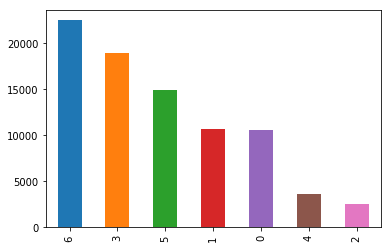

In [32]:
clusters.value_counts().plot(kind="bar") #

In [33]:
import kmodes.kprototypes as kpt

#, categorical=cat_idxs


#Xnum = np.asanyarray(X[:, [ii for ii in range(X.shape[1])
#                               if ii not in categorical]]).astype(np.float64)
#Xcat = np.asanyarray(X[:, categorical])


Xnum, Xcat = kpt._split_num_cat(df_sample_scat.values, cat_idxs)
Xnum, Xcat = kpt.check_array(Xnum), kpt.check_array(Xcat, dtype=None)
Xcat, _ = kpt.encode_features(Xcat, enc_map=kp._enc_map)
    

In [34]:
print(Xnum.shape, Xnum)
print(Xcat.shape, Xcat)

(83641, 45) [[-3.32281142e-01  3.51351440e-01  3.44677496e+00 ...  5.27724922e-08
  -8.49624038e-01 -1.35889435e+00]
 [-3.32281142e-01  3.51351440e-01  4.30378914e+00 ...  5.27724922e-08
  -8.49624038e-01 -1.35889435e+00]
 [-3.32281142e-01 -2.68017918e-01  2.63486695e+00 ... -1.34387299e-01
  -1.86466157e+00  3.54863852e-01]
 ...
 [-3.32281142e-01 -1.05630624e+00 -2.74469972e-01 ... -1.28063238e+00
  -4.13533822e-02 -6.88241303e-01]
 [-3.32281142e-01 -8.87387276e-01 -1.08637798e+00 ...  5.27724922e-08
   2.25563925e-02 -6.51773274e-01]
 [-3.32281142e-01 -9.99999881e-01 -2.97022969e-01 ... -4.50592846e-01
   2.18045101e-01  2.42351025e-01]]
(83641, 56) [[ 0  0  0 ...  4  3  0]
 [ 0  0  0 ...  4  3  0]
 [ 0  0  0 ...  4  3  0]
 ...
 [ 0  0  0 ... 29  2 18]
 [ 0  0  0 ... 19  3 21]
 [ 0  0  0 ... 48  2 18]]


In [60]:
distances = np.empty((n_points,kp.n_clusters), dtype=np.float32)
distances.shape

(83641, 7)

In [69]:
n_points = Xnum.shape[0]
labels = np.empty(n_points, dtype=np.uint16)
distances = np.empty((n_points,kp.n_clusters), dtype=np.float32)
for ipoint in range(n_points):
    num_costs = kp.num_dissim(kp.cluster_centroids_[0], Xnum[ipoint])
    cat_costs = kp.cat_dissim(kp.cluster_centroids_[1], Xcat[ipoint], X=Xcat)
    # Gamma relates the categorical cost to the numerical cost.
    tot_costs = num_costs + kp.gamma * cat_costs    
    clust = np.argmin(tot_costs)
    labels[ipoint] = clust
    distances[ipoint, :] = tot_costs

In [70]:
print(len(labels), labels)
print(distances.shape, distances)

83641 [1 1 1 ... 3 3 3]
(83641, 7) [[ 98.74969   73.2087   121.17412  ...  92.31548   92.04962   81.83843 ]
 [105.54222   70.005875 130.31917  ...  91.62957  100.2179    94.531944]
 [ 33.214737  18.532385  68.039536 ...  46.288975  31.739445  27.526085]
 ...
 [ 23.394352  30.050697  38.269234 ...  51.995914  25.002176  21.20905 ]
 [ 20.052372  28.46677   41.04244  ...  50.791573  21.743     20.313347]
 [ 17.563774  31.985403  29.766798 ...  54.451675  25.187862  23.42641 ]]


In [71]:
print((labels == clusters.values).all())

True


In [38]:
#carat_table = pd.crosstab(index=clusters.values, columns=y_sample.values)

In [39]:
#print(clusters)
#print(y_sample)

In [40]:
#class_dict = {'0': 0, '3': 1, '6': 2, '9': 3, 'C': 4, 'F': 5, 'R': 6}
#carat_table.index = ['Cluster_'+str(i) for i in sorted(clusters.value_counts().index.values)]
#carat_table.columns = ['Class_'+ elem for elem in class_dict.keys()]

#print(carat_table)
#print(carat_table.sum().sum())

In [41]:
#my_plot = carat_table.plot(kind="bar", figsize=(15,8),stacked=True)
##rot = 70 if (len(col_index.unique()) >= 10) else 0     
#my_plot.set_xticklabels(carat_table.index, rotation=0)    
##my_plot.set_xlabel('')
#my_plot.get_figure().savefig("kprototypes_Clusters_Classes.png")

In [66]:
##plt.show()
##plt.close()
##plt.clf()
print(len(kp.labels_), kp.labels_)
print(kp.gamma)
#print(df_sample_scat.values.shape)

83641 [1 1 1 ... 3 3 3]
0.33348051167286696


In [82]:
for c, ds, values in zip(clusters.values, distances, df_sample_scat.values):
    arr = np.append(np.append(float(c), np.array(ds)), values)
    print(arr)

[ 1.00000000e+00  9.87496872e+01  7.32087021e+01  1.21174118e+02
  9.34281158e+01  9.23154831e+01  9.20496216e+01  8.18384323e+01
 -3.32281142e-01  0.00000000e+00  3.51351440e-01  0.00000000e+00
  3.44677496e+00  0.00000000e+00 -2.82901794e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -5.64550096e-09  1.00000000e+00
 -1.13043487e+00  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  2.59999990e+00  0.00000000e+00
  8.89801443e-01  3.27011490e+00 -1.15956917e-01 -2.03524873e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
  5.76470613e+00  0.00000

[ 1.00000000e+00  3.79465027e+01  2.26346035e+01  7.68095627e+01
  3.74930763e+01  2.99078560e+01  3.90449715e+01  2.27807846e+01
 -3.32281142e-01  0.00000000e+00  1.25225234e+00  0.00000000e+00
  1.73274696e+00  0.00000000e+00 -6.76206291e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -5.64550096e-09  1.00000000e+00
  2.94685990e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  1.80833328e+00  0.00000000e+00
 -1.80698144e+00  1.54597700e+00  1.26064646e+00 -8.54486823e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 1.00000000e+00  2.70673981e+01  1.69082584e+01  5.92875786e+01
  2.67375355e+01  4.28341827e+01  2.37561111e+01  2.01842690e+01
 -3.32281142e-01  0.00000000e+00  3.05855960e-01  0.00000000e+00
  2.38678408e+00  0.00000000e+00 -4.21394706e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -1.54618442e-01  0.00000000e+00
 -3.72463763e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  1.20833325e+00  0.00000000e+00
  6.98151946e-01  8.08045983e-01 -9.63057995e-01 -5.16926825e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 5.00000000e+00  3.03344727e+01  2.36336689e+01  6.06850929e+01
  2.60858459e+01  5.88631706e+01  2.12084351e+01  2.18037930e+01
 -3.32281142e-01  0.00000000e+00 -2.46846750e-01  0.00000000e+00
  1.75530005e+00  0.00000000e+00 -5.29165745e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -2.41822794e-01  0.00000000e+00
 -7.76811600e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  8.83333266e-01  0.00000000e+00
  1.25941133e+00 -6.32183552e-02 -1.51000512e+00 -5.36514461e-01
  3.50737035e-01  0.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 5.00000000e+00  1.72359238e+01  1.62375069e+01  5.96568108e+01
  2.06442585e+01  3.66789207e+01  6.99468231e+00  1.52245750e+01
 -3.32281142e-01  0.00000000e+00  4.07657743e-01  0.00000000e+00
  8.75733018e-01  0.00000000e+00 -6.71606541e-01  0.00000000e+00
 -1.47881374e-01  0.00000000e+00 -1.76277891e-01  0.00000000e+00
 -1.69082079e-02  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  7.83333242e-01  0.00000000e+00
  8.76112223e-01  4.68390822e-01 -1.23037457e+00 -7.22596824e-01
 -1.40663445e-01  0.00000000e+00 -1.88544989e+00  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 4.00000000e+00  3.07549648e+01  1.68643703e+01  6.42919846e+01
  2.23061352e+01  9.78711796e+00  2.50791035e+01  1.05675831e+01
 -3.32281142e-01  0.00000000e+00  1.25225234e+00  0.00000000e+00
 -3.64681959e-01  0.00000000e+00 -3.95595670e-01  0.00000000e+00
 -1.45301253e-01  0.00000000e+00 -1.45831332e-01  0.00000000e+00
  4.73429978e-01  0.00000000e+00 -1.05963814e-07  5.20817300e-09
  3.37384809e-09  2.03776573e-09 -5.57052715e-09  1.34110456e-09
  0.00000000e+00  1.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  1.49999988e+00  0.00000000e+00
 -4.92813110e-01  1.54597700e+00 -3.81221145e-01 -5.95277309e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 4.00000000e+00  4.12865448e+01  3.06671867e+01  7.20167847e+01
  3.73330994e+01  1.92253017e+01  4.21887627e+01  2.62320347e+01
 -3.32281142e-01  0.00000000e+00  1.72522533e+00  0.00000000e+00
 -8.15741956e-01  0.00000000e+00 -2.78683215e-01  0.00000000e+00
 -1.45862147e-01  0.00000000e+00 -6.52828291e-02  0.00000000e+00
  1.07246375e+00  0.00000000e+00 -1.05963814e-07  5.20817300e-09
  3.37384809e-09  2.03776573e-09 -5.57052715e-09  1.34110456e-09
  0.00000000e+00  1.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  1.34166658e+00  0.00000000e+00
 -2.19028056e-01  2.14942527e+00  6.44946098e-01 -4.88851219e-01
 -1.86670756e+00  0.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 4.00000000e+00  3.56383896e+01  2.04240017e+01  7.35986710e+01
  3.21208420e+01  1.16165648e+01  3.79006615e+01  2.13843231e+01
 -3.32281142e-01  0.00000000e+00  1.13963974e+00  0.00000000e+00
  8.98285985e-01  0.00000000e+00 -4.99357253e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -1.89473972e-01  0.00000000e+00
  5.94202936e-01  0.00000000e+00 -1.05963814e-07  5.20817300e-09
  3.37384809e-09  2.03776573e-09 -5.57052715e-09  1.34110456e-09
  0.00000000e+00  1.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  1.08333325e+00  0.00000000e+00
 -2.69678283e+00  1.40229893e+00  4.91021037e-01 -6.77871764e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 4.00000000e+00  4.87596741e+01  3.65291481e+01  7.84088058e+01
  4.62219505e+01  1.88970470e+01  5.37329483e+01  3.87606544e+01
 -3.32281142e-01  0.00000000e+00  1.63963974e+00  0.00000000e+00
 -4.54893947e-01  0.00000000e+00  1.99154601e-01  0.00000000e+00
 -1.47881374e-01  0.00000000e+00  1.36281118e-01  0.00000000e+00
  1.55555558e+00  0.00000000e+00 -1.05963814e-07  5.20817300e-09
  3.37384809e-09  2.03776573e-09 -5.57052715e-09  1.34110456e-09
  0.00000000e+00  1.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  3.49999964e-01  0.00000000e+00
 -6.16016388e-01  2.03448272e+00  1.00410461e+00  7.94308633e-03
 -5.62363205e-08  1.00000000e+00 -1.13028072e-07  1.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
  1.12196979e-07  1.00000

[ 5.00000000e+00  1.94161396e+01  2.36562119e+01  5.21128082e+01
  1.81594982e+01  3.15319252e+01  8.68865204e+00  1.10858021e+01
 -3.32281142e-01  0.00000000e+00 -4.27926965e-02  0.00000000e+00
 -9.51059937e-01  0.00000000e+00 -1.76248312e-01  0.00000000e+00
 -1.47881374e-01  0.00000000e+00 -1.55662922e-02  0.00000000e+00
 -5.53140104e-01  0.00000000e+00 -1.05963814e-07  5.20817300e-09
  3.37384809e-09  2.03776573e-09 -5.57052715e-09  1.34110456e-09
  0.00000000e+00  1.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  8.74999940e-01  0.00000000e+00
 -8.62422943e-01 -1.06321804e-01 -5.64392030e-01 -3.66755038e-01
 -5.62363205e-08  1.00000000e+00 -1.88544989e+00  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 4.00000000e+00  3.05888386e+01  2.06236191e+01  6.39237862e+01
  2.16046391e+01  1.54627619e+01  2.42328377e+01  1.58758726e+01
 -3.32281142e-01  0.00000000e+00  7.79279351e-01  0.00000000e+00
 -9.73612964e-01  0.00000000e+00 -4.78998452e-01  0.00000000e+00
 -1.47881374e-01  0.00000000e+00 -2.12505460e-01  0.00000000e+00
  5.12077332e-01  0.00000000e+00 -1.05963814e-07  5.20817300e-09
  3.37384809e-09  2.03776573e-09 -5.57052715e-09  1.34110456e-09
  0.00000000e+00  1.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  5.58333278e-01  0.00000000e+00
 -5.47570109e-01  9.42528784e-01 -1.46536684e+00 -6.93215430e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
  1.12196979e-07  1.00000

[ 6.00000000e+00  2.58543205e+01  2.56712761e+01  6.16287003e+01
  2.59835052e+01  2.44016171e+01  2.65707760e+01  1.04033136e+01
 -3.32281142e-01  0.00000000e+00  1.08333337e+00  0.00000000e+00
 -5.90211928e-01  0.00000000e+00 -3.75555754e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -5.64550096e-09  1.00000000e+00
 -3.45410645e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  2.59999990e+00  0.00000000e+00
  5.47570109e-01  1.33045983e+00  6.54694736e-01 -5.78301370e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  3.51744576e+01  2.47261982e+01  6.15733147e+01
  2.61491470e+01  2.92530060e+01  2.94261475e+01  1.46648521e+01
 -3.32281142e-01  0.00000000e+00  5.76576650e-01  0.00000000e+00
 -2.51916975e-01  0.00000000e+00 -3.27903815e-02  0.00000000e+00
 -1.47881374e-01  0.00000000e+00 -2.59720795e-02  0.00000000e+00
 -1.59420297e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  1.34166658e+00  0.00000000e+00
 -8.35044444e-01  6.83908105e-01  7.47562826e-01 -2.07442403e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.86785185e-01  0.00000000e+00 -2.17361666e-08  1.00000000e+00
  2.82352948e+00  0.00000

[ 1.00000000e+00  4.46680374e+01  1.73364468e+01  8.80478668e+01
  4.19443932e+01  4.78653984e+01  4.54751358e+01  4.61189995e+01
 -3.32281142e-01  0.00000000e+00  7.45495558e-01  0.00000000e+00
  4.73229599e+00  0.00000000e+00 -8.48392606e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -1.81076124e-01  0.00000000e+00
  1.30676329e+00  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00 -8.75000000e-01  0.00000000e+00
  7.52908945e-01  8.99425328e-01 -5.86454630e-01 -8.89091611e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 1.00000000e+00  4.93473206e+01  2.03670368e+01  9.04907761e+01
  4.33845444e+01  3.91787224e+01  4.45232201e+01  4.58188896e+01
 -3.32281142e-01  0.00000000e+00  1.36486495e+00  0.00000000e+00
  3.60464597e+00  0.00000000e+00 -7.94872999e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -2.79148728e-01  0.00000000e+00
  1.55072474e+00  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00 -1.50000021e-01  0.00000000e+00
  1.23203278e+00  1.68965518e+00 -2.05233455e+00 -8.89091611e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -4.23380762e-01  0.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  3.05806389e+01  3.52800751e+01  6.25599823e+01
  3.33128624e+01  3.81545753e+01  3.31604385e+01  1.86385136e+01
 -3.32281142e-01  0.00000000e+00  5.76576650e-01  0.00000000e+00
 -7.48082936e-01  0.00000000e+00 -2.72242248e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -5.64550096e-09  1.00000000e+00
 -6.43478274e-01  0.00000000e+00 -1.41414240e-01  1.70873797e+00
  1.73584914e+00 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  2.17666650e+00  0.00000000e+00
 -6.98151946e-01  6.83908105e-01  1.45202652e-01 -4.77751583e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  3.12402840e+01  2.98957615e+01  6.38373299e+01
  2.53877678e+01  3.96336441e+01  2.61154728e+01  1.08150959e+01
 -3.32281142e-01  0.00000000e+00  2.38738835e-01  0.00000000e+00
 -8.38294923e-01  0.00000000e+00 -4.37419802e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -5.64550096e-09  1.00000000e+00
 -1.04830921e+00  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  2.24999976e+00  0.00000000e+00
  1.36892535e-02  2.52873600e-01  1.25705492e+00 -6.47837400e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -5.80991030e-01  0.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  3.03992767e+01  3.75709686e+01  6.11375427e+01
  3.22078476e+01  3.92759094e+01  2.21069317e+01  1.79875698e+01
 -3.32281142e-01  0.00000000e+00  2.95045137e-01  0.00000000e+00
 -9.96165931e-01  0.00000000e+00 -6.88777491e-02  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -5.64550096e-09  1.00000000e+00
 -9.59903419e-01  0.00000000e+00 -1.40404046e+00 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  2.20166659e+00  0.00000000e+00
 -1.75222445e+00  3.24712664e-01  2.34479204e-01 -2.68816948e-01
 -5.62363205e-08  1.00000000e+00 -1.88544989e+00  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  2.30178394e+01  1.97783680e+01  4.60666580e+01
  2.13097076e+01  3.56726456e+01  1.98231678e+01  1.13863192e+01
 -3.32281142e-01  0.00000000e+00  6.89189255e-01  0.00000000e+00
  7.40415037e-01  0.00000000e+00  2.29653791e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -5.64550096e-09  1.00000000e+00
 -5.37198067e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  2.20166659e+00  0.00000000e+00
  6.43394887e-01  8.27586234e-01 -5.38737833e-01  1.22935481e-01
 -1.00061429e+00  0.00000000e+00  4.95502532e-01  0.00000000e+00
  2.45587289e-01  0.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[ 6.00000000e+00  3.72727318e+01  2.50459576e+01  7.40638351e+01
  3.37985840e+01  3.71698875e+01  2.01668110e+01  1.85669060e+01
 -3.32281142e-01  0.00000000e+00  1.08333337e+00  0.00000000e+00
  1.03360403e+00  0.00000000e+00 -7.78350472e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -5.64550096e-09  1.00000000e+00
 -2.87439615e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  2.49999976e+00  0.00000000e+00
  1.36892533e+00  1.33045983e+00 -1.18009392e-02 -8.85827005e-01
 -5.62363205e-08  1.00000000e+00 -1.88544989e+00  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  2.58801441e+01  2.26052799e+01  5.94635963e+01
  1.90246029e+01  2.88044777e+01  1.90259171e+01  1.02638025e+01
 -3.32281142e-01  0.00000000e+00  6.32882953e-01  0.00000000e+00
 -9.73612964e-01  0.00000000e+00 -5.81950188e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -5.64550096e-09  1.00000000e+00
 -2.05314010e-01  0.00000000e+00 -8.98989975e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  1.52499986e+00  0.00000000e+00
  1.01300478e+00  7.55747139e-01 -1.04822993e+00 -7.97682703e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  3.07421799e+01  1.46606264e+01  6.27236595e+01
  1.78623219e+01  2.40991020e+01  2.41537819e+01  1.22530870e+01
 -3.32281142e-01  0.00000000e+00  4.07657743e-01  0.00000000e+00
  3.34461033e-01  0.00000000e+00 -3.96045238e-01  0.00000000e+00
 -1.47881374e-01  0.00000000e+00 -1.81777552e-01  0.00000000e+00
  2.29468614e-01  0.00000000e+00  1.11111008e-01  7.37864077e-01
  1.73584914e+00 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  3.58333290e-01  0.00000000e+00
 -3.96988362e-01  4.68390822e-01  1.00410461e+00 -5.71935415e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  2.82656403e+01  2.15846252e+01  5.99577255e+01
  2.37927113e+01  4.34802437e+01  2.66055450e+01  1.54482031e+01
 -3.32281142e-01  0.00000000e+00  8.58108163e-01  0.00000000e+00
  7.85521030e-01  0.00000000e+00 -6.10511243e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -5.64550096e-09  1.00000000e+00
  4.10628095e-02  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  1.51666653e+00  0.00000000e+00
  2.19028056e-01 -3.44827250e-02  1.26064646e+00 -7.92152464e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 1.00000000e+00  3.44216957e+01  1.46350174e+01  7.49231186e+01
  2.87836952e+01  3.66478577e+01  3.90627975e+01  3.40837898e+01
 -3.32281142e-01  0.00000000e+00  6.89189255e-01  0.00000000e+00
  3.24379802e+00  0.00000000e+00 -5.58541834e-01  0.00000000e+00
 -1.37420312e-01  0.00000000e+00 -1.60657659e-01  0.00000000e+00
  8.11594248e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00 -1.25000030e-01  0.00000000e+00
 -2.73785070e-02  8.27586234e-01  1.24730635e+00 -5.57701707e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  1.48162804e+01  1.70152683e+01  5.07609291e+01
  1.58852348e+01  2.58662758e+01  1.83086815e+01  5.01796865e+00
 -3.32281142e-01  0.00000000e+00  5.76576650e-01  0.00000000e+00
 -3.19575965e-01  0.00000000e+00 -2.47298956e-01  0.00000000e+00
 -1.47881374e-01  0.00000000e+00 -8.30112100e-02  0.00000000e+00
 -3.23671490e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  1.62499988e+00  0.00000000e+00
  2.87474334e-01  6.83908105e-01  7.47562826e-01 -3.48473281e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 1.00000000e+00  2.47866440e+01  9.80642128e+00  5.92079201e+01
  1.45345163e+01  1.40189486e+01  2.28967667e+01  1.01177969e+01
 -3.32281142e-01  0.00000000e+00  6.89189255e-01  0.00000000e+00
  1.99143022e-01  0.00000000e+00 -4.40915942e-01  0.00000000e+00
 -1.44521609e-01  0.00000000e+00 -5.64550096e-09  1.00000000e+00
  5.31400979e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  3.58333290e-01  0.00000000e+00
 -9.58247721e-01  8.27586234e-01  1.20933807e+00 -6.28778636e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  2.97521801e+01  1.53787746e+01  6.57656631e+01
  2.02453384e+01  2.14239864e+01  1.27301579e+01  9.27336216e+00
 -3.32281142e-01  0.00000000e+00  8.01801860e-01  0.00000000e+00
 -2.63869688e-02  0.00000000e+00 -6.89818203e-01  0.00000000e+00
 -1.47881374e-01  0.00000000e+00 -2.71471590e-01  0.00000000e+00
  1.93236768e-02  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  1.44999993e+00  0.00000000e+00
 -3.55920583e-01  9.71264422e-01 -3.09389442e-01 -8.79297793e-01
 -5.62363205e-08  1.00000000e+00 -1.09179902e+00  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 1.00000000e+00  1.25625095e+01  1.00084219e+01  3.37591705e+01
  1.36236429e+01  2.31445465e+01  1.85099316e+01  1.03518076e+01
 -3.32281142e-01  0.00000000e+00  6.32882953e-01  0.00000000e+00
  1.25913405e+00  0.00000000e+00  7.15728521e-01  0.00000000e+00
 -1.47881374e-01  0.00000000e+00  3.58656645e-01  0.00000000e+00
  2.72946864e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  6.99999928e-01  0.00000000e+00
  4.51745361e-01  7.55747139e-01  1.13904551e-01  7.23622561e-01
 -5.62363205e-08  1.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

[ 6.00000000e+00  1.79852772e+01  9.58430958e+00  5.03207436e+01
  1.27359743e+01  2.89740963e+01  1.29575109e+01  7.77733374e+00
 -3.32281142e-01  0.00000000e+00  2.38738835e-01  0.00000000e+00
  1.19147503e+00  0.00000000e+00 -3.64119440e-01  0.00000000e+00
 -1.46066315e-09  1.00000000e+00 -1.62183836e-01  0.00000000e+00
 -2.99516916e-01  0.00000000e+00  6.16161525e-01 -2.33009711e-01
 -1.50943398e-01 -1.62393168e-01 -1.40186921e-01 -5.99999987e-02
 -2.25225225e-01  0.00000000e+00 -8.08823526e-01  1.00000000e+00
 -6.94610775e-01  1.00000000e+00 -6.38095260e-01  1.00000000e+00
  5.75581372e-01  1.00000000e+00 -1.28048599e-01  1.00000000e+00
 -3.78880948e-01  1.00000000e+00  3.41081433e-02  1.00000000e+00
 -9.91942361e-03  1.00000000e+00  9.58333254e-01  0.00000000e+00
 -6.84462637e-02  2.52873600e-01 -2.68342763e-01 -4.95380431e-01
 -2.94226080e-01  0.00000000e+00  4.95502532e-01  0.00000000e+00
 -2.40793483e-08  1.00000000e+00 -2.17361666e-08  1.00000000e+00
 -1.17646948e-01  0.00000

KeyboardInterrupt: 

In [83]:
print(arr.shape)

(109,)


In [84]:
neighborhood = [np.append(np.append(float(c), np.array(ds)), values) for c, ds, values in zip(clusters.values, distances, df_sample_scat.values)]
neighborhood = np.array(neighborhood)
print(neighborhood.shape, neighborhood)

(83641, 109) [[  1.          98.74968719  73.20870209 ...   4.           3.
    0.        ]
 [  1.         105.54222107  70.00587463 ...   4.           3.
    0.        ]
 [  1.          33.21473694  18.53238487 ...   4.           3.
    0.        ]
 ...
 [  3.          23.39435196  30.05069733 ...  29.           2.
   18.        ]
 [  3.          20.05237198  28.46677017 ...  19.           3.
   21.        ]
 [  3.          17.56377411  31.98540306 ...  48.           2.
   18.        ]]


In [85]:
np.savetxt("kprototypes_details_alld_C_C.csv", neighborhood, delimiter=";")